### Importing necessary Libraries:

In [1]:
import numpy as np
from numpy import sqrt, abs
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import statsmodels.api as sm
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.weightstats import ztest
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import mpu

import warnings
warnings.filterwarnings('ignore')

### Importing Dataset:

In [2]:
nyc_trip_duration = pd.read_csv('nyc_taxi_trip_duration.csv')
nyc_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848
...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447


In [3]:
# Shape of the dataset:
nyc_trip_duration.shape

(729322, 11)

In [4]:
# List of all the columns provided:
nyc_trip_duration.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [5]:
# Data types of all the columns of the NYC taxi duration dataset:
nyc_trip_duration.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [6]:
# Checking if there are any Null or missing values in the datset:
nyc_trip_duration.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
# Checking the how many unique values are in each feature:
nyc_trip_duration.nunique()

id                    729322
vendor_id                  2
pickup_datetime       709359
dropoff_datetime      709308
passenger_count            9
pickup_longitude       19729
pickup_latitude        39776
dropoff_longitude      27892
dropoff_latitude       53579
store_and_fwd_flag         2
trip_duration           6296
dtype: int64

### Feature creation:

In [8]:
# Function to convert hour to part of the day (Morning, evening, etc.):
def hour_to_time_of_day(i):
    
    if i >= 4 and i < 8:
        return 'Early Morning'
    elif i >= 8 and i < 12:
        return 'Morning'
    elif i >= 12 and i < 15:
        return 'Afternoon'
    elif i >= 15 and i < 17:
        return 'Late Afternoon'
    elif i >= 17 and i < 21:
        return 'Evening'
    elif i in [21,22,23,24,0,1,2,3]:
        return 'Night'
    else:
        return 'Not an hour of the day'

In [9]:
# Converting date time information to the date time data type:
nyc_trip_duration['pickup_datetime'] = pd.to_datetime(nyc_trip_duration['pickup_datetime'])
nyc_trip_duration['dropoff_datetime'] = pd.to_datetime(nyc_trip_duration['dropoff_datetime'])

# Extracting Year, Month, Day name, hour of the day converted to categories (Morning, Noon, etc.):
nyc_trip_duration['pickup_year'] = nyc_trip_duration['pickup_datetime'].dt.year
nyc_trip_duration['pickup_month'] = nyc_trip_duration['pickup_datetime'].dt.month_name()
nyc_trip_duration['End/start year?'] = nyc_trip_duration['pickup_month'].apply(lambda x: 'Jan/Dec' if x in ['January','December'] else 'Other_months')
nyc_trip_duration['pickup_day_name'] = nyc_trip_duration['pickup_datetime'].dt.day_name()
nyc_trip_duration['pickup_weekend?'] = nyc_trip_duration['pickup_day_name'].apply(lambda x: 'weekend' if x in ['Saturday','Sunday'] else 'weekday')
nyc_trip_duration['pickup_hour'] = nyc_trip_duration['pickup_datetime'].dt.hour

nyc_trip_duration['dropoff_year'] = nyc_trip_duration['dropoff_datetime'].dt.year
nyc_trip_duration['dropoff_month'] = nyc_trip_duration['dropoff_datetime'].dt.month_name()
nyc_trip_duration['dropoff_day_name'] = nyc_trip_duration['dropoff_datetime'].dt.day_name()
nyc_trip_duration['dropoff_weekend?'] = nyc_trip_duration['dropoff_day_name'].apply(lambda x: 'weekend' if x in ['Saturday','Sunday'] else 'weekday')
nyc_trip_duration['dropoff_hour'] = nyc_trip_duration['dropoff_datetime'].dt.hour


# Converting Pickkup and Dropoff hours to Time of the day:
nyc_trip_duration['pickup_hour'] = nyc_trip_duration['pickup_hour'].apply(hour_to_time_of_day)
nyc_trip_duration['dropoff_hour'] = nyc_trip_duration['dropoff_hour'].apply(hour_to_time_of_day)

In [10]:
# Calculating trip distance using latitude and longitude information:
nyc_trip_duration['trip_distance'] = list(map(mpu.haversine_distance, zip(nyc_trip_duration['pickup_latitude'], nyc_trip_duration['pickup_longitude']), zip(nyc_trip_duration['dropoff_latitude'], nyc_trip_duration['dropoff_longitude'])))

In [11]:
#Calculate Speed in km/h for further insights
nyc_trip_duration['trip_speed'] = (nyc_trip_duration.trip_distance/(nyc_trip_duration.trip_duration/3600))

* #Note: The below code is to get the address form the latitude and longitude information. But the code is taking too long to run so it is kept on pause for now

In [12]:
# ## Getting the exact pickup and dropoff address from the latitude and longitude data:
# # Initialize Nominatim API
# geolocator = Nominatim(user_agent="testing")
# rgeocode = RateLimiter(geolocator.reverse, min_delay_seconds=0.1)

# # Converting the data type of latitude and logitude to string:
# nyc_trip_duration['pickup_latitude'] = nyc_trip_duration['pickup_latitude'].astype(str)
# nyc_trip_duration['pickup_longitude'] = nyc_trip_duration['pickup_longitude'].astype(str)
# nyc_trip_duration['dropoff_latitude'] = nyc_trip_duration['dropoff_latitude'].astype(str)
# nyc_trip_duration['dropoff_longitude'] = nyc_trip_duration['dropoff_longitude'].astype(str)

# # Get location with geocode:
# nyc_trip_duration['pickup_location'] = nyc_trip_duration['pickup_latitude']+','+ nyc_trip_duration['pickup_longitude']
# nyc_trip_duration['pickup_location'] = nyc_trip_duration['pickup_location'].apply(rgeocode) 

# nyc_trip_duration['dropoff_location'] = nyc_trip_duration['dropoff_latitude']+','+ nyc_trip_duration['dropoff_longitude']
# nyc_trip_duration['dropoff_location'] = nyc_trip_duration['dropoff_location'].apply(rgeocode) 

In [13]:
# def get_suburb(row):
#     location = row["pickup_location"]
    
#     try:
#         return location.raw["address"]["suburb"]
#     except KeyError:
#         return " "

# def get_city(row):
#     location = row["pickup_location"]
#     try:
#         return location.raw["address"]["city"]
#     except KeyError:
#         return " "

# def get_state(row):
#     location = row["pickup_location"]
#     try:
#         return location.raw["address"]["state"]
#     except KeyError:
#         return " "
    
# temp["CITY"] = temp.apply(get_suburb, axis=1)
# temp["SUBURB"] = temp.apply(get_city, axis=1)
# temp["STATE"] = temp.apply(get_state, axis=1)

# display(temp)

In [14]:
# Converting trip duration from seconds to minutes for better interpretability:
nyc_trip_duration['trip_duration'] = round(nyc_trip_duration['trip_duration'] / 60,2)

# Function to classify trip duration and turn it into a categorical variable:
def classify_trip_duration(x):
    if x <= 15:
        return 'short trip'
    elif x > 15 and x <= 60:
        return 'medium trip'
    elif x > 60 and x <= 120:
        return 'long trip'
    else:
        return 'very long trip'

# Creating a new categorical column for the trip duration:
nyc_trip_duration['trip_duration_class'] = nyc_trip_duration['trip_duration'].apply(classify_trip_duration)

In [15]:
nyc_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekend?,pickup_hour,dropoff_year,dropoff_month,dropoff_day_name,dropoff_weekend?,dropoff_hour,trip_distance,trip_speed,trip_duration_class
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,weekday,Late Afternoon,2016,February,Monday,weekday,Late Afternoon,1.199073,10.791654,short trip
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,weekday,Night,2016,March,Friday,weekday,Night,4.129111,13.513454,medium trip
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,weekend,Evening,2016,February,Sunday,weekend,Evening,7.250753,15.964960,medium trip
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,weekday,Morning,2016,January,Tuesday,weekday,Morning,2.361097,7.449562,medium trip
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,weekday,Early Morning,2016,February,Wednesday,weekday,Early Morning,4.328534,18.375851,short trip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,...,weekend,Afternoon,2016,May,Saturday,weekend,Afternoon,1.120223,13.624333,short trip
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,...,weekday,Night,2016,February,Monday,weekday,Night,0.728705,8.328053,short trip
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,...,weekday,Evening,2016,April,Friday,weekday,Evening,2.298776,12.296570,short trip
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,...,weekend,Morning,2016,June,Sunday,weekend,Morning,0.846316,6.815966,short trip


### Variable Identification and Type casting:

In [16]:
nyc_trip_duration.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag             object
trip_duration                 float64
pickup_year                     int64
pickup_month                   object
End/start year?                object
pickup_day_name                object
pickup_weekend?                object
pickup_hour                    object
dropoff_year                    int64
dropoff_month                  object
dropoff_day_name               object
dropoff_weekend?               object
dropoff_hour                   object
trip_distance                 float64
trip_speed                    float64
trip_duration_class            object
dtype: object

### Integer Data Type:

In [17]:
print(nyc_trip_duration.dtypes[nyc_trip_duration.dtypes == 'int64'])

vendor_id          int64
passenger_count    int64
pickup_year        int64
dropoff_year       int64
dtype: object


* There are only 2 vendor_ids and hence it must be converted into a category
* passenger_count can stay as integer
* trip_duration is the target variable, ideally it should be converted into a float but its not a big problem if stays as integer
* Pickup_year and dropoff_year should be converted to categories as they are years in which the trip took place

In [18]:
nyc_trip_duration['vendor_id'] = nyc_trip_duration['vendor_id'].astype('category')
nyc_trip_duration['pickup_year'] = nyc_trip_duration['pickup_year'].astype('category') 
nyc_trip_duration['dropoff_year'] = nyc_trip_duration['dropoff_year'].astype('category')
nyc_trip_duration['trip_duration'] = nyc_trip_duration['trip_duration'].astype('float64') 
print(nyc_trip_duration.dtypes[nyc_trip_duration.dtypes == 'int64'])

passenger_count    int64
dtype: object


### Object Data Type:

In [19]:
print(nyc_trip_duration.dtypes[nyc_trip_duration.dtypes == 'object'])

id                     object
store_and_fwd_flag     object
pickup_month           object
End/start year?        object
pickup_day_name        object
pickup_weekend?        object
pickup_hour            object
dropoff_month          object
dropoff_day_name       object
dropoff_weekend?       object
dropoff_hour           object
trip_duration_class    object
dtype: object


* id can stay as object as it has characters in it
* store and fwd flag has 2 categories N and Y so it needs to be converted into categorical data type
* All the pickup and dropoff information should be converted into categories

In [20]:
nyc_trip_duration['store_and_fwd_flag'] = nyc_trip_duration['store_and_fwd_flag'].astype('category')
nyc_trip_duration['pickup_month'] = nyc_trip_duration['pickup_month'].astype('category')
nyc_trip_duration['pickup_day_name'] = nyc_trip_duration['pickup_day_name'].astype('category')
nyc_trip_duration['pickup_hour'] = nyc_trip_duration['pickup_hour'].astype('category')
nyc_trip_duration['dropoff_month'] = nyc_trip_duration['dropoff_month'].astype('category')
nyc_trip_duration['dropoff_day_name'] = nyc_trip_duration['dropoff_day_name'].astype('category')
nyc_trip_duration['dropoff_hour'] = nyc_trip_duration['dropoff_hour'].astype('category')
nyc_trip_duration['trip_duration_class'] = nyc_trip_duration['trip_duration_class'].astype('category')
nyc_trip_duration['pickup_weekend?'] = nyc_trip_duration['pickup_weekend?'].astype('category')
nyc_trip_duration['dropoff_weekend?'] = nyc_trip_duration['dropoff_weekend?'].astype('category')

print(nyc_trip_duration.dtypes[nyc_trip_duration.dtypes == 'object'])

id                 object
End/start year?    object
dtype: object


### Float Data Type:

In [21]:
print(nyc_trip_duration.dtypes[nyc_trip_duration.dtypes == 'float64'])

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_duration        float64
trip_distance        float64
trip_speed           float64
dtype: object


* Pickup and Dropoff latitudes and longitudes have the right data type. No changes required in this segment
* Trip distance and Trip speed can stay the same as well

In [22]:
# Final check of the data types of NYC taxi trip duration dataset after changes:
nyc_trip_duration.dtypes

id                             object
vendor_id                    category
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag           category
trip_duration                 float64
pickup_year                  category
pickup_month                 category
End/start year?                object
pickup_day_name              category
pickup_weekend?              category
pickup_hour                  category
dropoff_year                 category
dropoff_month                category
dropoff_day_name             category
dropoff_weekend?             category
dropoff_hour                 category
trip_distance                 float64
trip_speed                    float64
trip_duration_class          category
dtype: object

### Exploring Continious Variables:

In [23]:
# Selecting only Integer and Float variables for understanding the spread of data:
nyc_trip_duration.select_dtypes(include=['int64','float64'])

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_distance,trip_speed
0,1,-73.953918,40.778873,-73.963875,40.771164,6.67,1.199073,10.791654
1,2,-73.988312,40.731743,-73.994751,40.694931,18.33,4.129111,13.513454
2,2,-73.997314,40.721458,-73.948029,40.774918,27.25,7.250753,15.964960
3,6,-73.961670,40.759720,-73.956779,40.780628,19.02,2.361097,7.449562
4,1,-74.017120,40.708469,-73.988182,40.740631,14.13,4.328534,18.375851
...,...,...,...,...,...,...,...,...
729317,2,-73.965919,40.789780,-73.952637,40.789181,4.93,1.120223,13.624333
729318,1,-73.996666,40.737434,-74.001320,40.731911,5.25,0.728705,8.328053
729319,1,-73.997849,40.761696,-74.001488,40.741207,11.22,2.298776,12.296570
729320,1,-74.006706,40.708244,-74.013550,40.713814,7.45,0.846316,6.815966


* **Latitudes** and **Longitudes** information is considered as **geographical information** and should not be analysed like regular continious variables
* We can observe the spread of the data in the **passenger_count**, **trip_speed** and **trip_duration** columns

#### Mean:

In [24]:
avg_passenger_count = math.ceil(nyc_trip_duration['passenger_count'].mean())
print(f'Average number of passengers who get inside a taxi: {avg_passenger_count} (rounded to ceiling)')

avg_trip_duration = round(nyc_trip_duration['trip_duration'].mean(),2)
print(f'Average trip duration of a taxi in NYC: {avg_trip_duration} seconds')

avg_trip_speed = round(nyc_trip_duration['trip_speed'].mean(),2)
print(f'Average trip duration of a taxi in NYC: {avg_trip_speed} seconds')

Average number of passengers who get inside a taxi: 2 (rounded to ceiling)
Average trip duration of a taxi in NYC: 15.87 seconds
Average trip duration of a taxi in NYC: 14.42 seconds


#### Median:

In [25]:
median_passenger_count = nyc_trip_duration['passenger_count'].median()
print(f'Median number of passengers who get inside a taxi: {median_passenger_count}')

median_trip_duration = round(nyc_trip_duration['trip_duration'].median(),2)
print(f'Median trip duration of a taxi in NYC: {median_trip_duration} seconds')

median_trip_speed = round(nyc_trip_duration['trip_speed'].median(),2)
print(f'Median trip duration of a taxi in NYC: {median_trip_speed} seconds')

Median number of passengers who get inside a taxi: 1.0
Median trip duration of a taxi in NYC: 11.05 seconds
Median trip duration of a taxi in NYC: 12.8 seconds


* **1** is the **50th percentile** of the passenger count
* **Mean > Median** and the difference between Mean and Median trip duration is significant indicating the **presence of outliers** in the data

#### Standard Deviation and Variance:

In [26]:
passenger_count_std = round(nyc_trip_duration['passenger_count'].std(),2)
print(f'Standard deviation of passenger count in a taxi: {passenger_count_std}')
passenger_count_var = round(nyc_trip_duration['passenger_count'].var(),2)
print(f'Variance of passenger count in a taxi: {passenger_count_var}')
print('\n')
trip_duration_std = round(nyc_trip_duration['trip_duration'].std(),2)
print(f'Standard deviation of trip duration of a taxi in NYC: {trip_duration_std}')
trip_duration_var = round(nyc_trip_duration['trip_duration'].var(),2)
print(f'Variance of trip_duration in a taxi: {trip_duration_var}')
print('\n')
trip_speed_std = round(nyc_trip_duration['trip_speed'].std(),2)
print(f'Standard deviation of trip speed of a taxi in NYC: {trip_speed_std}')
trip_speed_var = round(nyc_trip_duration['trip_speed'].var(),2)
print(f'Variance of trip speed in a taxi: {trip_speed_var}')

Standard deviation of passenger count in a taxi: 1.31
Variance of passenger count in a taxi: 1.72


Standard deviation of trip duration of a taxi in NYC: 64.41
Variance of trip_duration in a taxi: 4148.7


Standard deviation of trip speed of a taxi in NYC: 12.34
Variance of trip speed in a taxi: 152.3


* **High** standard deviation and variance values in the **trip duration** and **trip speed** indicate the presence of outliers

In [27]:
# Describe funtion for all the numerical variables:
nyc_trip_duration.describe(include=['int64','float64'])

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_distance,trip_speed
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000
mean,1.662055,-73.973513,40.750919,-73.973422,40.751775,15.870490,3.441139,14.421448
std,1.312446,0.069754,0.033594,0.069588,0.036037,64.410435,4.353132,12.341027
min,0.000000,-121.933342,34.712234,-121.933304,32.181141,0.020000,0.000000,0.000000
25%,1.000000,-73.991859,40.737335,-73.991318,40.735931,6.620000,1.232695,9.124310
50%,1.000000,-73.981758,40.754070,-73.979759,40.754509,11.050000,2.095672,12.796828
75%,2.000000,-73.967361,40.768314,-73.963036,40.769741,17.920000,3.876481,17.843917
max,9.000000,-65.897385,51.881084,-65.897385,43.921028,32328.930000,1240.908677,5640.493985


**Summary:**
 * **Latitudes** and **Longitudes** information is considered as **geographical information** and should not be analysed like regular continious variables
 * Average number of passengers who get inside a taxi: 2 (rounded to ceiling)
 * Average trip duration of a taxi in NYC is 952.23 seconds
 * **1** is the **50th percentile** of the passenger count
 * For trip duration **Mean > Median** and the difference between Mean and Median is significant indicating the **presence of outliers** in the data
 * **High** standard deviation and variance values in the **trip duration** indicate the presence of outliers

#### Univariate analysis of Numeric variables:

In [28]:
nyc_trip_duration.select_dtypes(include=['int64','float64'])

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_distance,trip_speed
0,1,-73.953918,40.778873,-73.963875,40.771164,6.67,1.199073,10.791654
1,2,-73.988312,40.731743,-73.994751,40.694931,18.33,4.129111,13.513454
2,2,-73.997314,40.721458,-73.948029,40.774918,27.25,7.250753,15.964960
3,6,-73.961670,40.759720,-73.956779,40.780628,19.02,2.361097,7.449562
4,1,-74.017120,40.708469,-73.988182,40.740631,14.13,4.328534,18.375851
...,...,...,...,...,...,...,...,...
729317,2,-73.965919,40.789780,-73.952637,40.789181,4.93,1.120223,13.624333
729318,1,-73.996666,40.737434,-74.001320,40.731911,5.25,0.728705,8.328053
729319,1,-73.997849,40.761696,-74.001488,40.741207,11.22,2.298776,12.296570
729320,1,-74.006706,40.708244,-74.013550,40.713814,7.45,0.846316,6.815966


##### Univariate analysis (Numerical) function definition:

In [29]:
# Function to perform univariate analysis of the numeric coloumns by checking normality, skewness and kurtosis:
def univariate_analysis_numeric(df, col_name):
    
    # Taking only the column data:
    df_col =df[col_name]
    
    # Checking for Skewness and Kurtosis:
    df_col_skewness = round(df_col.skew(),2)
    df_col_kurtosis = round(df_col.kurtosis(),2)
    print('{} Skewness: {}'.format(col_name,df_col_skewness))
    print('{} Kurtosis: {}'.format(col_name,df_col_kurtosis))

    # Mean, Median and Standard Deviation:
    df_col_mean = round(df_col.mean(),2)
    df_col_median = round(df_col.median(),2)
    df_col_var = round(df_col.var(),2)
    df_col_std = round(df_col.std(),2)
    df_col_min_max = round(df_col.min(),2), round(df_col.max(),2)
    # This is one standard deviation on either sides of the mean value:
    one_std_range = round(df_col_mean - df_col_std,2), round(df_col_mean + df_col_std,2) 
    print('{} mean: {}, median: {}'.format(col_name, df_col_mean, df_col_median))
    print('{} standard deviation: {}, one_std_range: {}'.format(col_name, df_col_std, one_std_range))
    print('{} variance: {}'.format(col_name, df_col_var))
    print('{} Min and Max: {}'.format(col_name, df_col_min_max))
    
    # Sub-plots:
    fig, axes = plt.subplots(1,3,figsize=(20,5), dpi=100)
    
    # Normality check (visual) - KDE Plot:
    sns.kdeplot(ax=axes[0], x=df_col, shade=True)
    sns.scatterplot(ax=axes[0], x=[df_col_mean], y=[0], color='red', label='Mean')
    sns.scatterplot(ax=axes[0], x=[df_col_median], y=[0], color='green', label='Median')
    sns.lineplot(ax=axes[0], x=list(one_std_range), y=[0,0], color='black', label='std_range')
    axes[0].set_title('{} - KDE'.format(col_name))
    axes[0].set_xlabel('{}'.format(col_name))
    axes[0].set_ylabel('Density')
    
    # Normality check - QQ Plot:
    sm.qqplot(df_col, line='s', ax=axes[1])
    axes[1].set_title('{} - QQ Plot'.format(col_name))
    
    # Box plot to check for outliers in the data:
    sns.boxplot(ax=axes[2], x=df_col, orient='v')
    axes[2].set_title('{} - Box plot'.format(col_name))
    axes[2].set_xlabel('{}'.format(col_name))
    
    plt.show()

##### Outlier handling funtion definition:

In [30]:
# Function to handle outliers:
def outlier_handling(df_original, col_name, method = 'IQR', replace = True):
    
    df = df_original.copy()
    
    # Handling outliers using IQR method:
    if method == 'IQR':        
        # 1st Quartile and 3rd Quartile: 
        Q1 = df[col_name].quantile(0.25)
        Q3 = df[col_name].quantile(0.75)
        # Interquartile range and whisker width:
        IQR = Q3-Q1
        whisker_width = 1.5
        # Lower and Upper whiskers:
        lower_whisker = Q1 - (whisker_width * IQR)
        upper_whisker = Q3 + (whisker_width * IQR)
        
        if replace == True:
            # Replacing outliers with respective whiskers:
            print('Replacing outliers using IQR')
            df.loc[df[col_name] > upper_whisker, col_name] = upper_whisker
            df.loc[df[col_name] < lower_whisker, col_name] = lower_whisker
        else:
            # Dropping outliers: (Not recommended as the entire row values of all columns are dropped along with the outliers leading to data loss)
            print('Dropping outliers using IQR')
            df = df.loc[df[col_name] <= upper_whisker]
            df = df.loc[df[col_name] >= lower_whisker]
    
    ## Handling outliers using Standard deviation method:
    elif method == 'STD':
        # Higher end standard deviation value (Mean + 3 * standard deviation):
        high_std_val = df[col_name].mean() + 3 * df[col_name].std()
        # Lower end standard deviation value (Mean - 3 * standard deviation):
        low_std_val = df[col_name].mean() - 3 * df[col_name].std()
        
        if replace == True:
            # Replacing outliers with higher and lower end standard deviation values of the column:
            print('Replacing outliers using Standard deviation')
            df.loc[df[col_name] > high_std_val, col_name] = high_std_val
            df.loc[df[col_name] > low_std_val, col_name] = low_std_val
        else:
            # Dropping outliers: (Not recommended as the entire row values of all columns are dropped along with the outliers leading to data loss)
            print('Dropping outliers using Standard deviation')
            df = df.loc[df[col_name] <= high_std_val] 
            df = df.loc[df[col_name] >= low_std_val] 
            
    return df

##### Univariate analysis of Passenger count in a taxi in NYC:

passenger_count Skewness: 2.14
passenger_count Kurtosis: 3.46
passenger_count mean: 1.66, median: 1.0
passenger_count standard deviation: 1.31, one_std_range: (0.35, 2.97)
passenger_count variance: 1.72
passenger_count Min and Max: (0, 9)


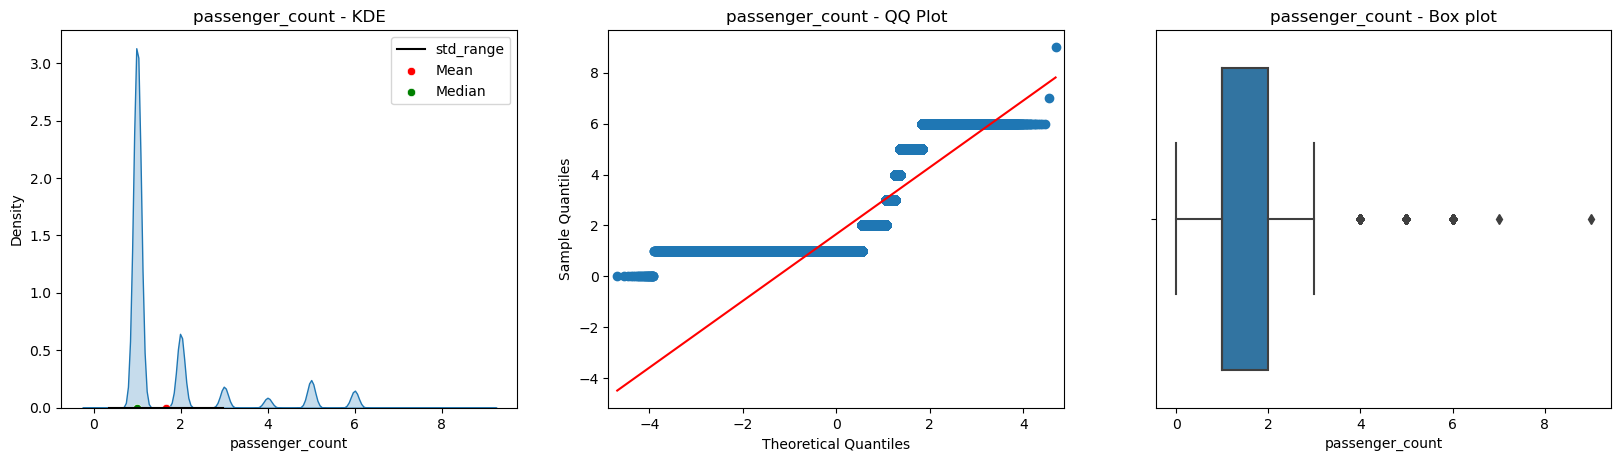

In [31]:
# Univariate analysis before handling outliers:
univariate_analysis_numeric(nyc_trip_duration, 'passenger_count')

* There are some trips with 0 passenger count
* Few trips even consisted of 7,8 and 9 passengers which are clearly outliers and point to data inconsistency
* Monst of the trips contain either 1 or 2 passengers
* **Pre-processing pointers:** Trips with 0 passenger count should be replaced with mode value which is 1

Replacing outliers using IQR
passenger_count Skewness: 1.51
passenger_count Kurtosis: 0.75
passenger_count mean: 1.49, median: 1.0
passenger_count standard deviation: 0.85, one_std_range: (0.64, 2.34)
passenger_count variance: 0.73
passenger_count Min and Max: (0.0, 3.5)


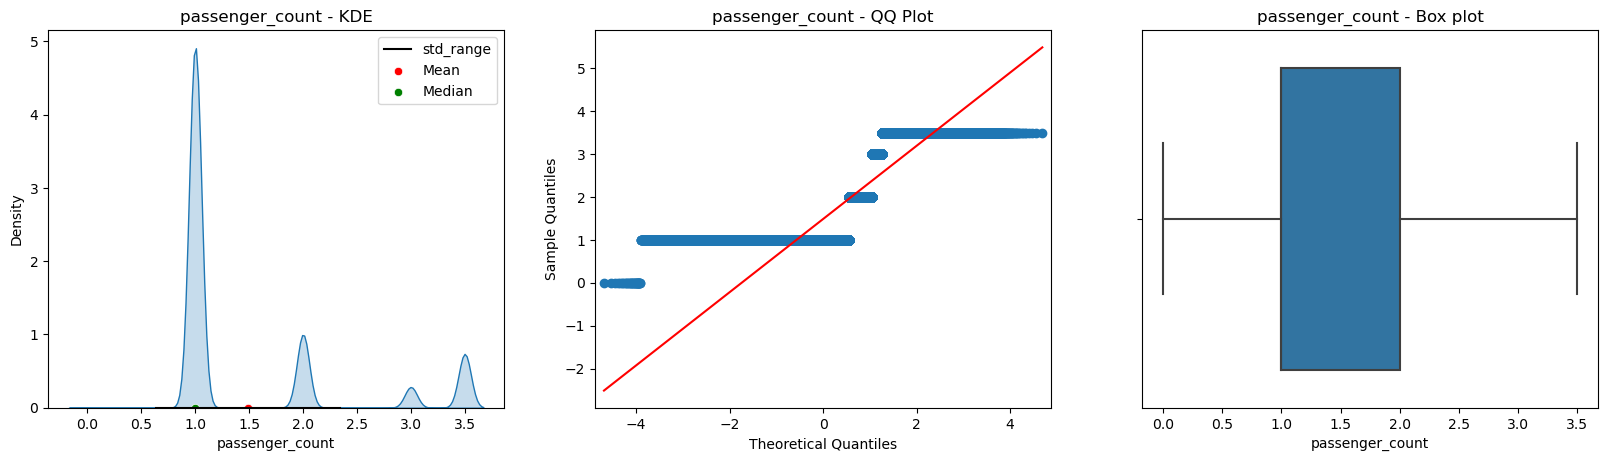

In [32]:
# Handling outliers
nyc_passenger_count_no_outliers = outlier_handling(nyc_trip_duration, 'passenger_count', method = 'IQR', replace = True)

# Univariate analysis after handling outliers to better understand the data:
univariate_analysis_numeric(nyc_passenger_count_no_outliers, 'passenger_count')

* The distribution is Bi-modal and the Mean > Median indicating presence of outliers
* The data is **not normally distributed** as observed from the QQ-plot (data points are not along the line) and the KDE plot (No symmetry)
* The data is **Right skewed** as the skewness value is > 0.5
* The Skewness value (1.15) is not within the range of -0.5 to 0.5 indicating that the data is not symmetric
* The Kurtosis value (0.75) is > 0 (**Leptokurtic**) which means fatter tail and longer distribution indicating the presence of **outliers**
* From the KDE plot we can observe that most of the time there is **only one customer in the taxi**

##### Univariate analysis of Trip duration of taxi in NYC:

trip_duration Skewness: 186.68
trip_duration Kurtosis: 87142.44
trip_duration mean: 15.87, median: 11.05
trip_duration standard deviation: 64.41, one_std_range: (-48.54, 80.28)
trip_duration variance: 4148.7
trip_duration Min and Max: (0.02, 32328.93)


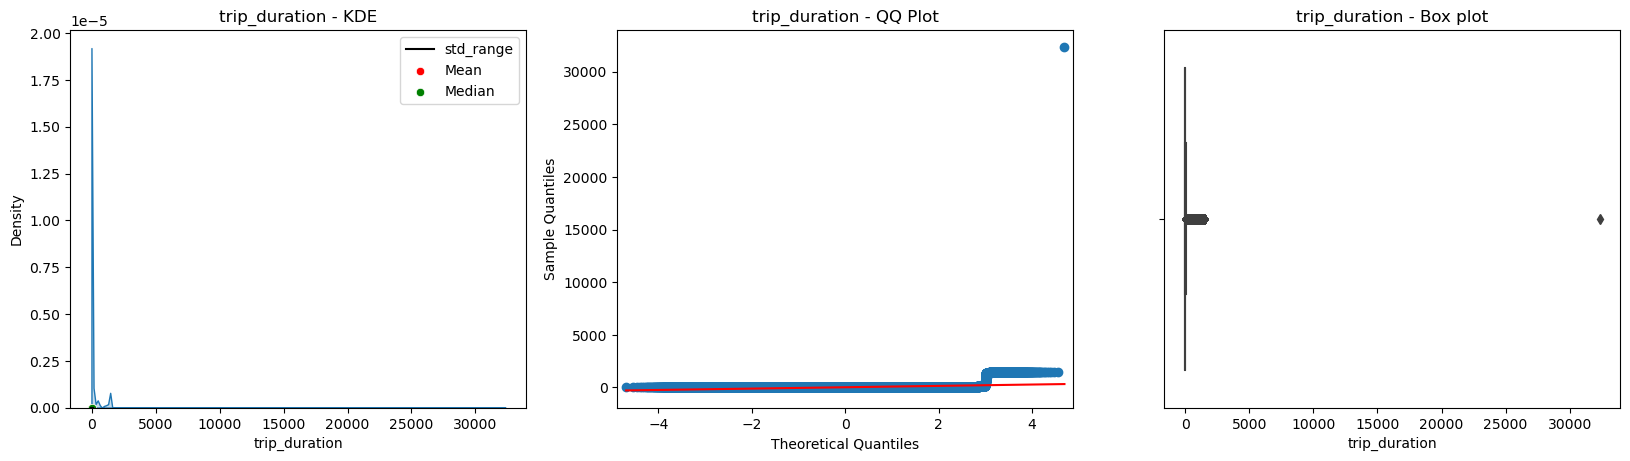

In [33]:
# Univariate analysis before handling outliers:
univariate_analysis_numeric(nyc_trip_duration, 'trip_duration')

In [34]:
nyc_trip_duration.trip_duration.groupby(pd.cut(nyc_trip_duration.trip_duration, np.arange(1,max(nyc_trip_duration.trip_duration),3600))).count()

trip_duration
(1.0, 3601.0]         724959
(3601.0, 7201.0]           0
(7201.0, 10801.0]          0
(10801.0, 14401.0]         0
(14401.0, 18001.0]         0
(18001.0, 21601.0]         0
(21601.0, 25201.0]         0
(25201.0, 28801.0]         0
Name: trip_duration, dtype: int64

* Trip duration for some trips is as low as 1 sec which can explain the reason for the trips with distance as 0 kms

Replacing outliers using IQR
trip_duration Skewness: 0.97
trip_duration Kurtosis: 0.14
trip_duration mean: 13.35, median: 11.05
trip_duration standard deviation: 8.81, one_std_range: (4.54, 22.16)
trip_duration variance: 77.7
trip_duration Min and Max: (0.02, 34.87)


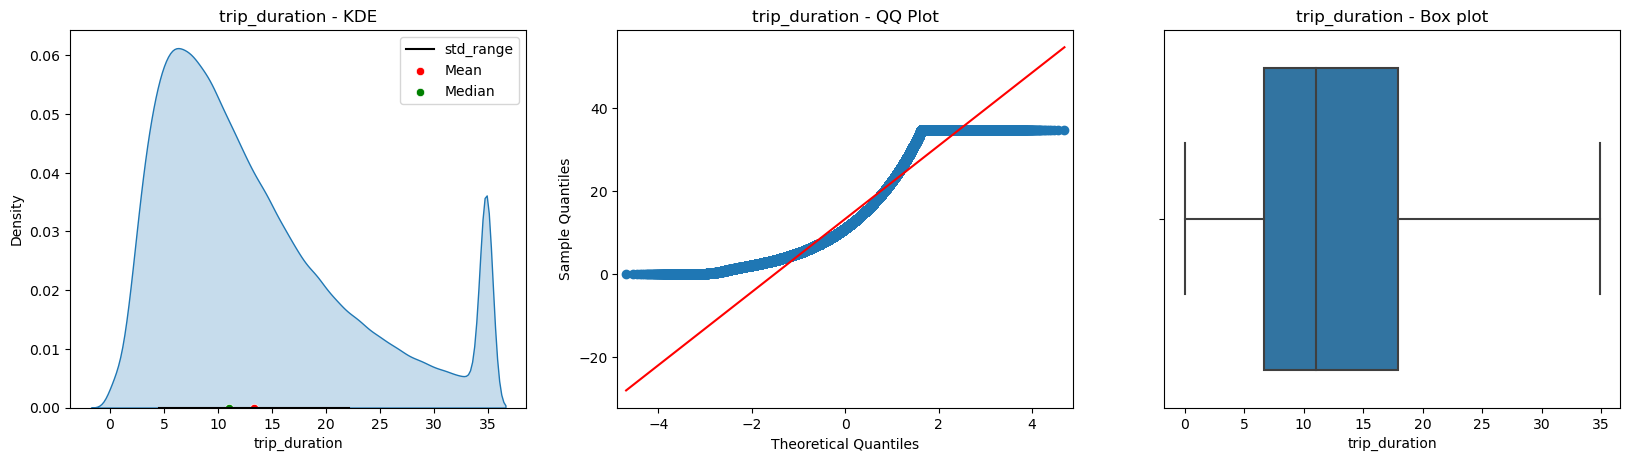

In [35]:
# Handling outliers
nyc_trip_duration_no_outliers = outlier_handling(nyc_trip_duration, 'trip_duration', method = 'IQR', replace = True)

# Univariate analysis after handling outliers to better understand the data:
univariate_analysis_numeric(nyc_trip_duration_no_outliers, 'trip_duration')

* **Mean > Median** indicating the presence of **some outliers**
* Skewness (0.97) > 0.5 meaning the data is **Right/positively skewed** 
* Since the skewness value is only slightly greater than 0, there is some level of symmetry
* The Kurtosis value (0.14) is > 0 meaning it is **leptokurtic**
* Kurtosis value is only slightly greater than 0 indicating there are few outliers
* From the KDE plot we can observe that most of the trip durations are between **250 - 1300 seconds** which is between **4 mins - 22 mins** (one standard deviation values)

##### Univariate analysis of Trip distance of taxi in NYC:

trip_distance Skewness: 40.98
trip_distance Kurtosis: 9795.09
trip_distance mean: 3.44, median: 2.1
trip_distance standard deviation: 4.35, one_std_range: (-0.91, 7.79)
trip_distance variance: 18.95
trip_distance Min and Max: (0.0, 1240.91)


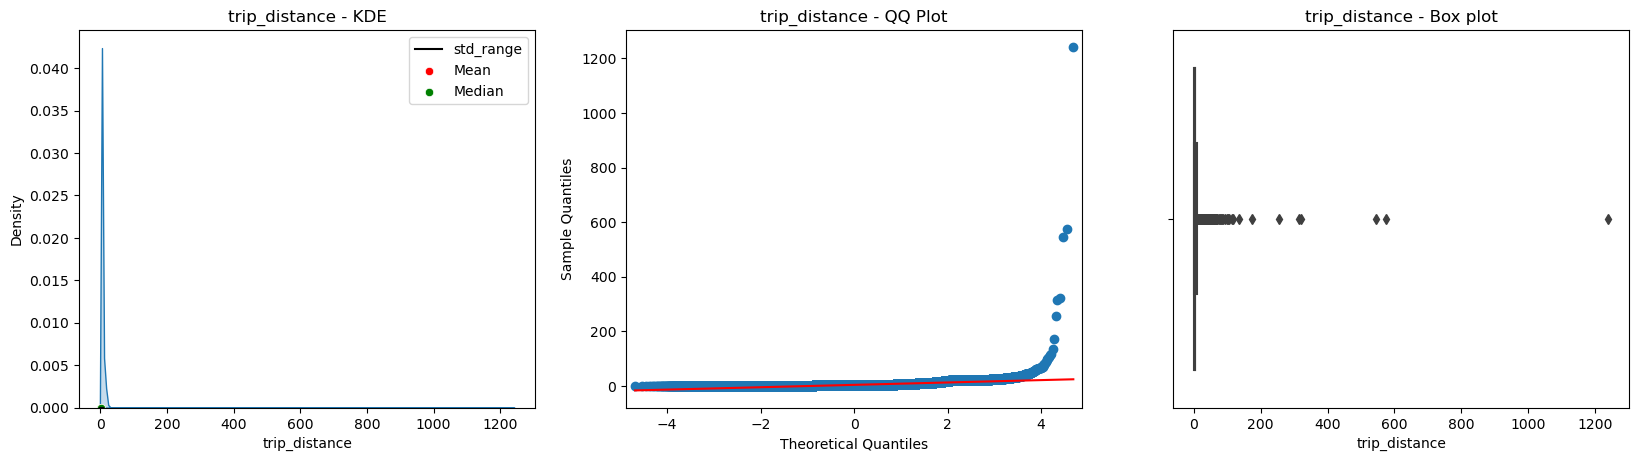

In [36]:
# Univariate analysis before handling outliers:
univariate_analysis_numeric(nyc_trip_duration, 'trip_distance')

In [37]:
print("There are {} trip records with 0 km distance".format(nyc_trip_duration.trip_distance[nyc_trip_duration.trip_distance == 0 ].count()))

There are 2901 trip records with 0 km distance


* There are some trips that are over 100 km and some of them are 0 km
* Average distance travelled is 3.5 km and standard deviation of 4.35 shows that most of the trips were between 1-10 kms
* There are 2901 trips that have trip distance as 0 km

Replacing outliers using IQR
trip_distance Skewness: 1.09
trip_distance Kurtosis: 0.03
trip_distance mean: 2.9, median: 2.1
trip_distance standard deviation: 2.25, one_std_range: (0.65, 5.15)
trip_distance variance: 5.04
trip_distance Min and Max: (0.0, 7.84)


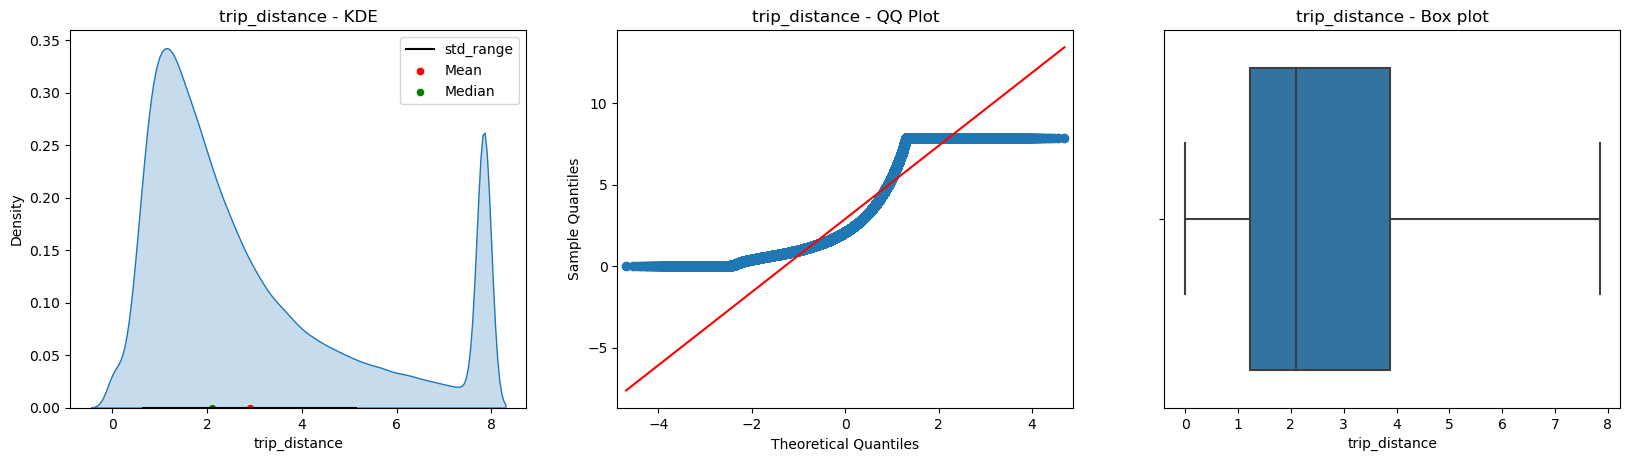

In [38]:
# Handling outliers
nyc_trip_distance_no_outliers = outlier_handling(nyc_trip_duration, 'trip_distance', method = 'IQR', replace = True)

# Univariate analysis after handling outliers to better understand the data:
univariate_analysis_numeric(nyc_trip_distance_no_outliers, 'trip_distance')

* Most of the trips completed are between the range of 1-9 kms

##### Univariate analysis of Trip speed of taxi in NYC:

trip_speed Skewness: 194.01
trip_speed Kurtosis: 76874.41
trip_speed mean: 14.42, median: 12.8
trip_speed standard deviation: 12.34, one_std_range: (2.08, 26.76)
trip_speed variance: 152.3
trip_speed Min and Max: (0.0, 5640.49)


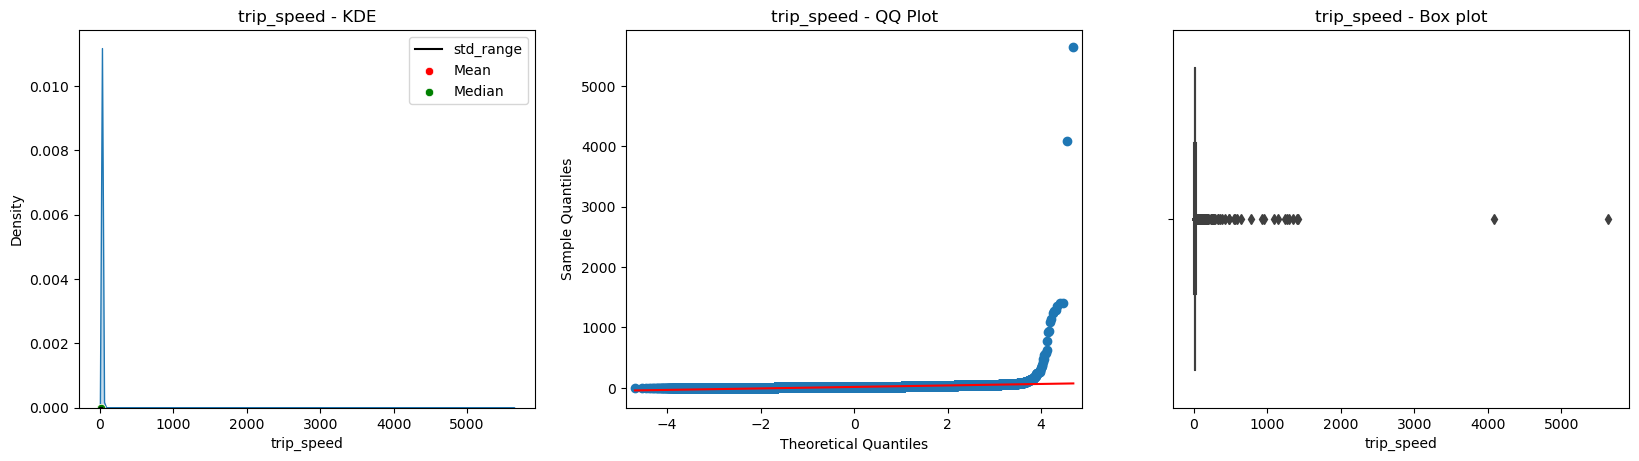

In [39]:
# Univariate analysis before handling outliers:
univariate_analysis_numeric(nyc_trip_duration, 'trip_speed')

* There are many trips that are going at super sonic speeds (200km/hr+). These outliers need to be handled

Replacing outliers using IQR
trip_speed Skewness: 0.73
trip_speed Kurtosis: 0.07
trip_speed mean: 14.1, median: 12.8
trip_speed standard deviation: 6.9, one_std_range: (7.2, 21.0)
trip_speed variance: 47.65
trip_speed Min and Max: (0.0, 30.92)


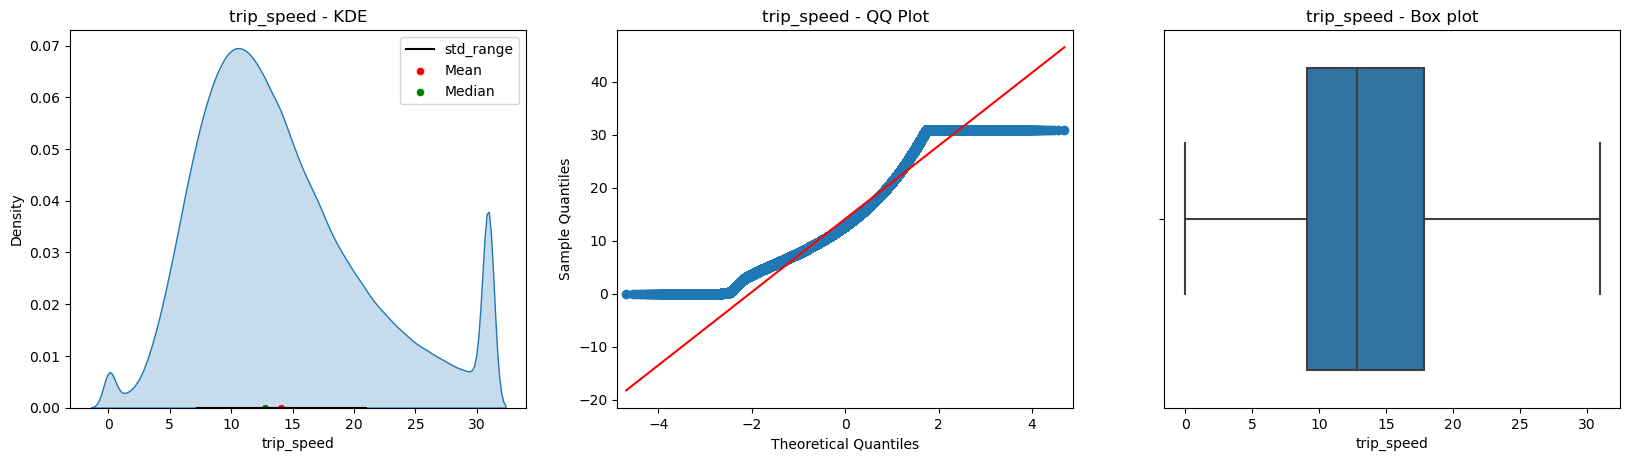

In [40]:
# Handling outliers
nyc_trip_speed_no_outliers = outlier_handling(nyc_trip_duration, 'trip_speed', method = 'IQR', replace = True)

# Univariate analysis after handling outliers to better understand the data:
univariate_analysis_numeric(nyc_trip_speed_no_outliers, 'trip_speed')

* Most trips are done between 10-20 km/hr speed with an average speed of 14 km/hr

#### Exploring Categorical variables:

In [36]:
# Displaying object and categorical variables:
display(nyc_trip_duration.select_dtypes(include=['object','category']))
# Displaying the data types of variables:
print(nyc_trip_duration.select_dtypes(include=['object','category']).dtypes)

,id,vendor_id,store_and_fwd_flag,pickup_year,pickup_month,End/start year?,pickup_day_name,pickup_weekend?,pickup_hour,dropoff_year,dropoff_month,dropoff_day_name,dropoff_weekend?,dropoff_hour,trip_duration_class
0,id1080784,2,N,2016,February,Other_months,Monday,weekday,Late Afternoon,2016,February,Monday,weekday,Late Afternoon,short trip
1,id0889885,1,N,2016,March,Other_months,Friday,weekday,Night,2016,March,Friday,weekday,Night,medium trip
2,id0857912,2,N,2016,February,Other_months,Sunday,weekend,Evening,2016,February,Sunday,weekend,Evening,medium trip
3,id3744273,2,N,2016,January,Jan/Dec,Tuesday,weekday,Morning,2016,January,Tuesday,weekday,Morning,medium trip
4,id0232939,1,N,2016,February,Other_months,Wednesday,weekday,Early Morning,2016,February,Wednesday,weekday,Early Morning,short trip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,N,2016,May,Other_months,Saturday,weekend,Afternoon,2016,May,Saturday,weekend,Afternoon,short trip
729318,id0102861,1,N,2016,February,Other_months,Monday,weekday,Night,2016,February,Monday,weekday,Night,short trip
729319,id0439699,1,N,2016,April,Other_months,Friday,weekday,Evening,2016,April,Friday,weekday,Evening,short trip
729320,id2078912,1,N,2016,June,Other_months,Sunday,weekend,Morning,2016,June,Sunday,weekend,Morning,short trip


id                       object
vendor_id              category
store_and_fwd_flag     category
pickup_year            category
pickup_month           category
End/start year?          object
pickup_day_name        category
pickup_weekend?        category
pickup_hour            category
dropoff_year           category
dropoff_month          category
dropoff_day_name       category
dropoff_weekend?       category
dropoff_hour           category
trip_duration_class    category
dtype: object


#### Mode:

In [37]:
mode_vendor_id = nyc_trip_duration['vendor_id'].mode()[0]
print(f'Mode of vendor_id is: {mode_vendor_id}')

mode_store_and_fwd_flag = nyc_trip_duration['store_and_fwd_flag'].mode()[0]
print(f'Mode of store and forward flag of a taxi in NYC: {mode_store_and_fwd_flag}')

mode_pickup_year = nyc_trip_duration['pickup_year'].mode()[0]
print(f'Mode of pickup_year of a taxi in NYC: {mode_pickup_year}')

mode_pickup_month = nyc_trip_duration['pickup_month'].mode()[0]
print(f'Mode of pickup_month of a taxi in NYC: {mode_pickup_month}')

mode_pickup_day_name = nyc_trip_duration['pickup_day_name'].mode()[0]
print(f'Mode of pickup_day_name of a taxi in NYC: {mode_pickup_day_name}')

mode_pickup_hour = nyc_trip_duration['pickup_hour'].mode()[0]
print(f'Mode of pickup_hour of a taxi in NYC: {mode_pickup_hour}')

mode_trip_duration_class = nyc_trip_duration['trip_duration_class'].mode()[0]
print(f'Mode of trip_duration_class of a taxi in NYC: {mode_trip_duration_class}')

Mode of vendor_id is: 2
Mode of store and forward flag of a taxi in NYC: N
Mode of pickup_year of a taxi in NYC: 2016
Mode of pickup_month of a taxi in NYC: March
Mode of pickup_day_name of a taxi in NYC: Friday
Mode of pickup_hour of a taxi in NYC: Night
Mode of trip_duration_class of a taxi in NYC: short trip


##### Univariate analysis (Categorical) function definition:

In [38]:
# Function to perform univariate analysis for the categorical variables:
def univariate_analysis_categorical(df, col_name):
    
    # Getting unique no.of categories:
    category_unique = df[col_name].nunique()
    # Filtering only top 10 categories to display visually:
    if category_unique > 5:
        # calculating the percentages for each category within each variable:
        category_percentages = df[col_name].value_counts(normalize=True)[:10]
        category_frequencies = df[col_name].value_counts()[:10]
    else:
        # calculating the percentages for each category within each variable:
        category_percentages = df[col_name].value_counts(normalize=True)
        category_frequencies = df[col_name].value_counts()
    
    # Plotting the bar graph for the variable to visually represent each categories and their frequencies:
    fig, axes = plt.subplots(1,2,figsize=(20,7), dpi=100)
    
    axy = sns.barplot(ax=axes[0], x=category_frequencies.index, y=category_frequencies.values, order=category_frequencies.index)
    for p in axy.patches:
        axy.annotate('{:1.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=15)
        
    axes[0].set_xlabel('{}'.format(col_name), fontsize=20)
    axes[0].set_ylabel('Frequency', fontsize=20)
    axes[0].set_title('{} frequency'.format(col_name), fontsize=15)
    
    
    # Plotting the bar graph for the variable to visually represent each categories and their frequencies:
    axy = sns.barplot(ax=axes[1],x=category_percentages.index, y=category_percentages.values, order=category_percentages.index)
    for p in axy.patches:
        axy.annotate('{:1.2f}'.format(p.get_height()*100), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=15)
        
    axes[1].set_xlabel('{}'.format(col_name), fontsize=20)
    axes[1].set_ylabel('Fraction/Percentages', fontsize=20)
    axes[1].set_title('{} percentages'.format(col_name), fontsize=15)
    
    plt.show()

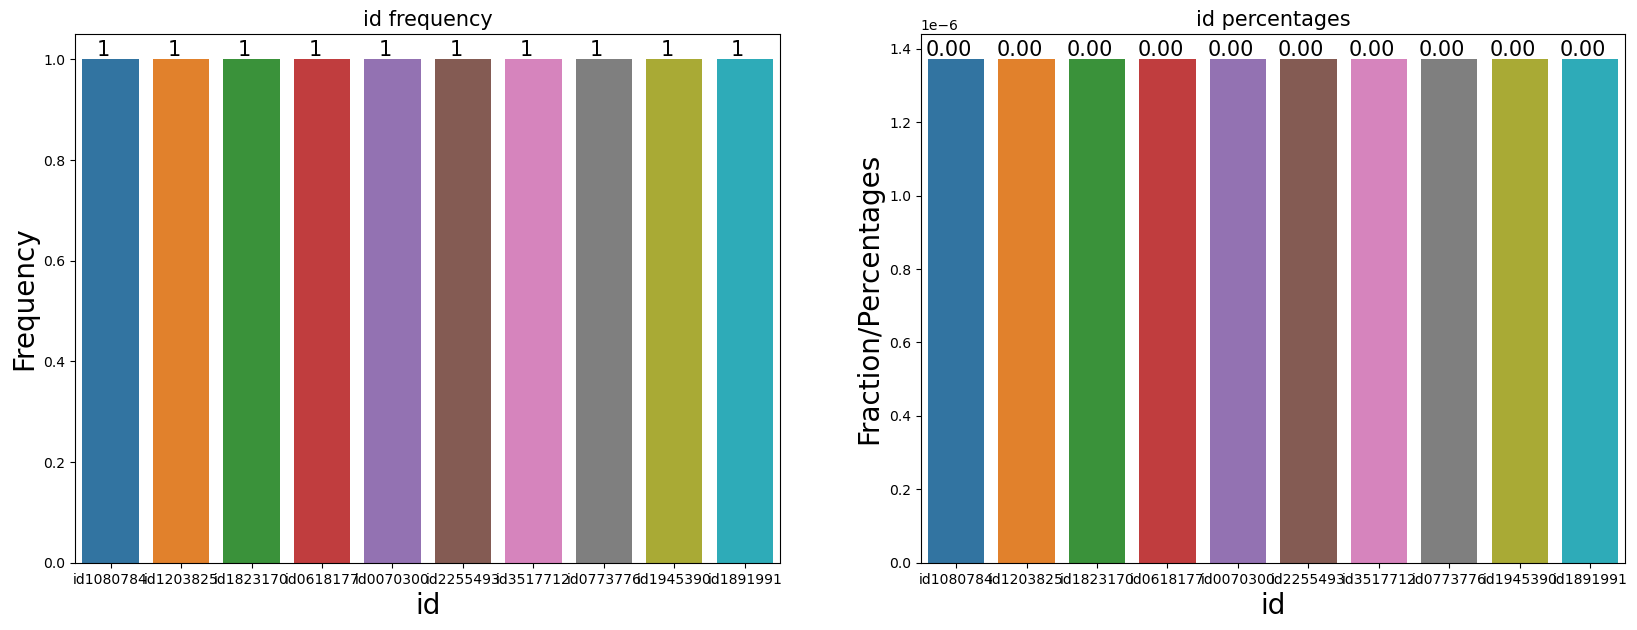

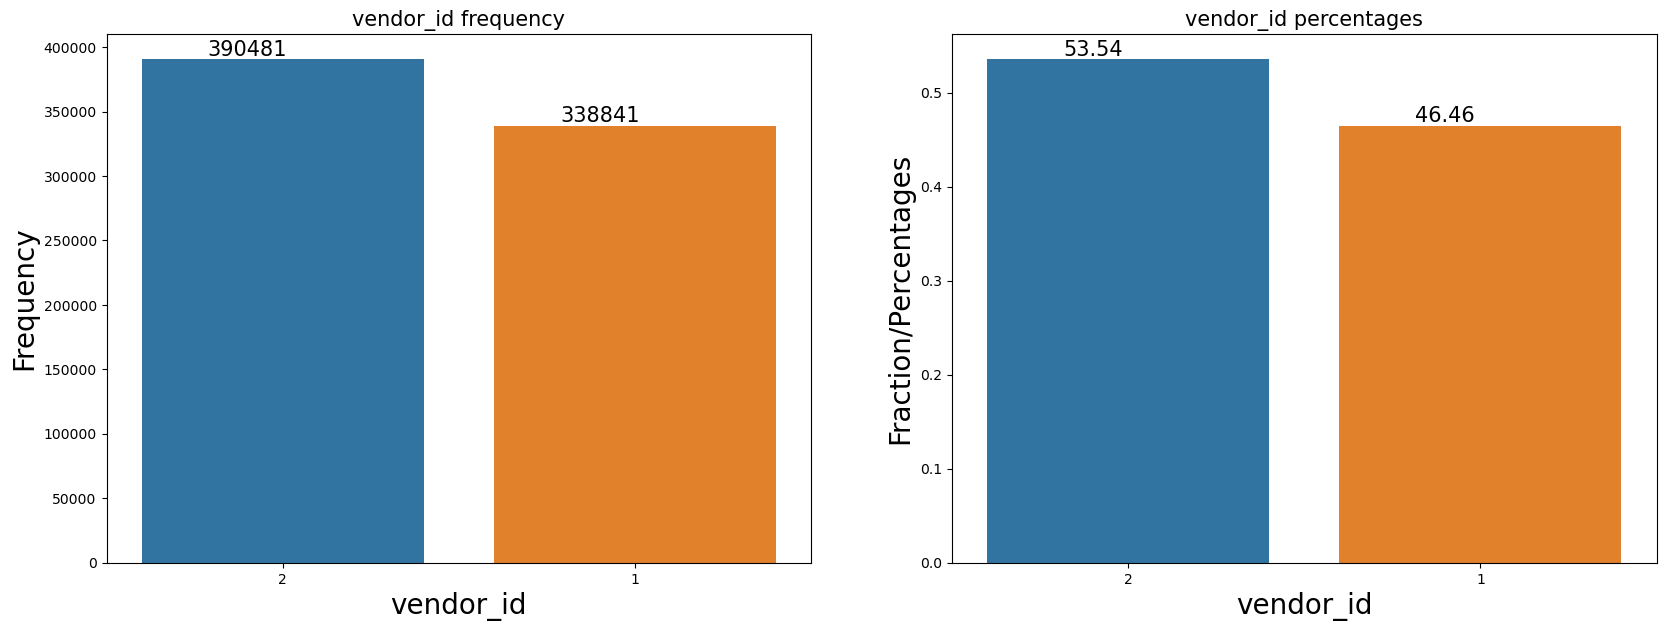

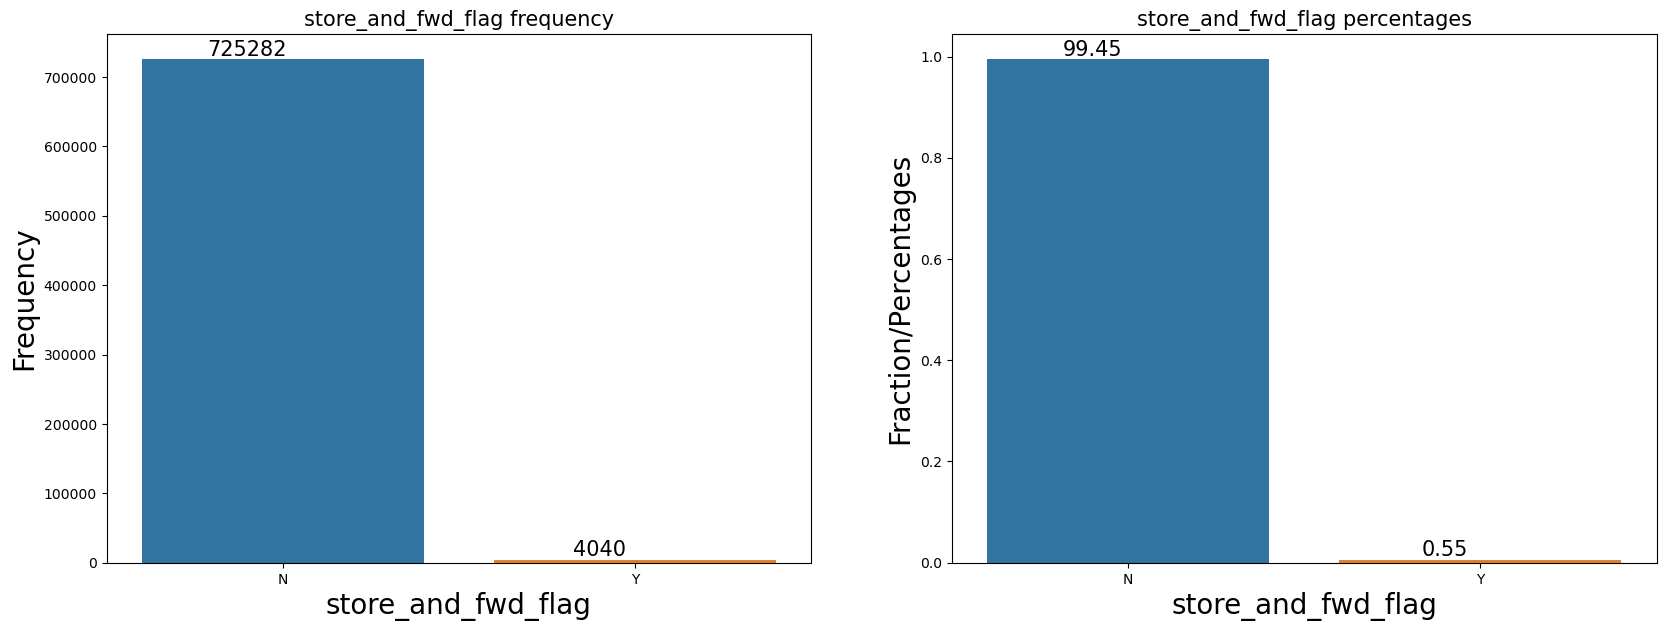

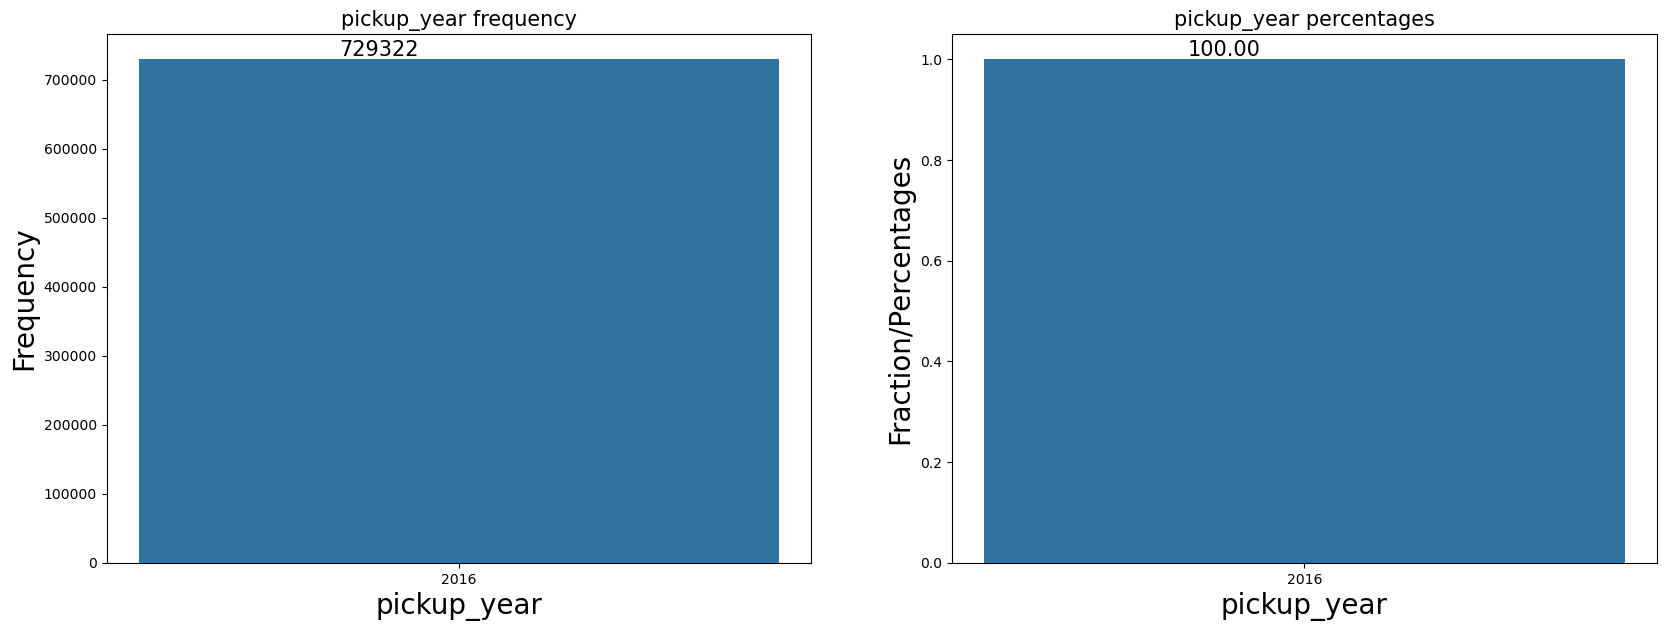

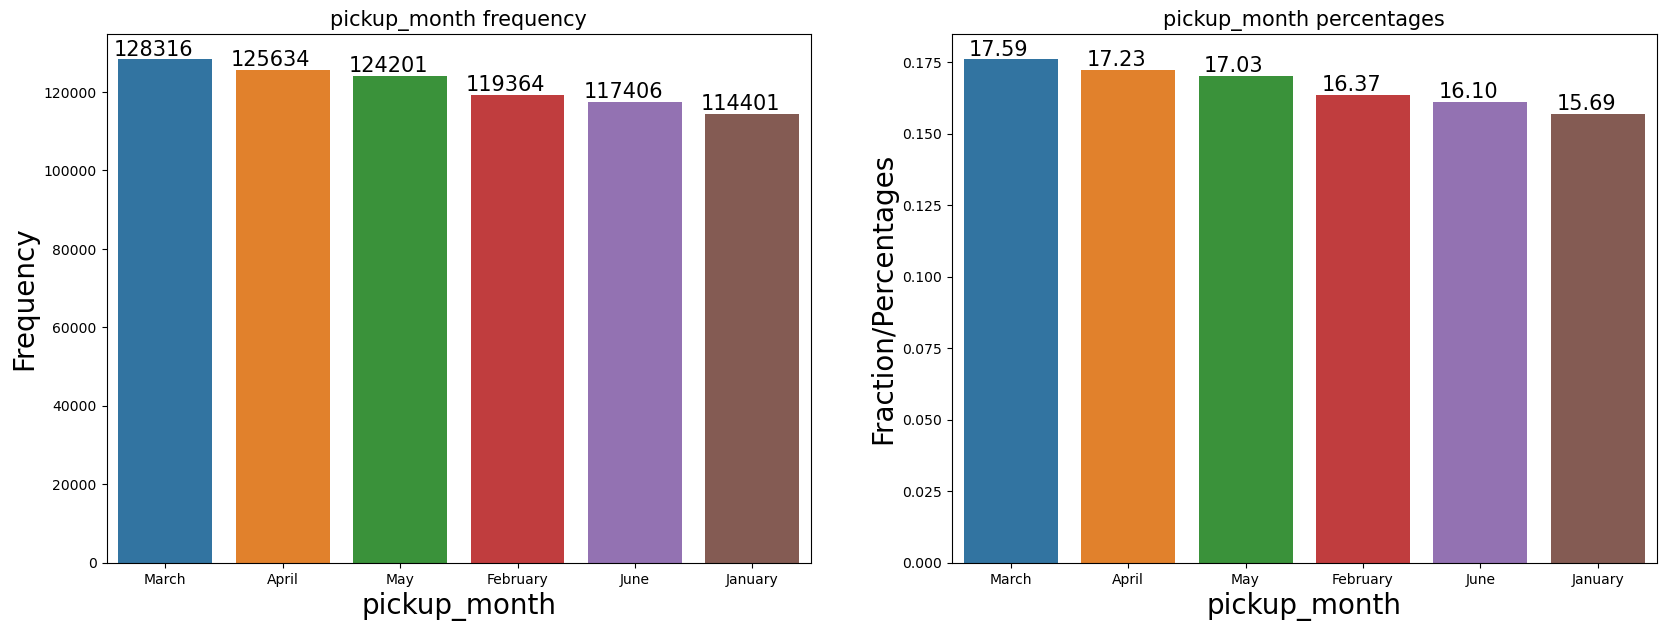

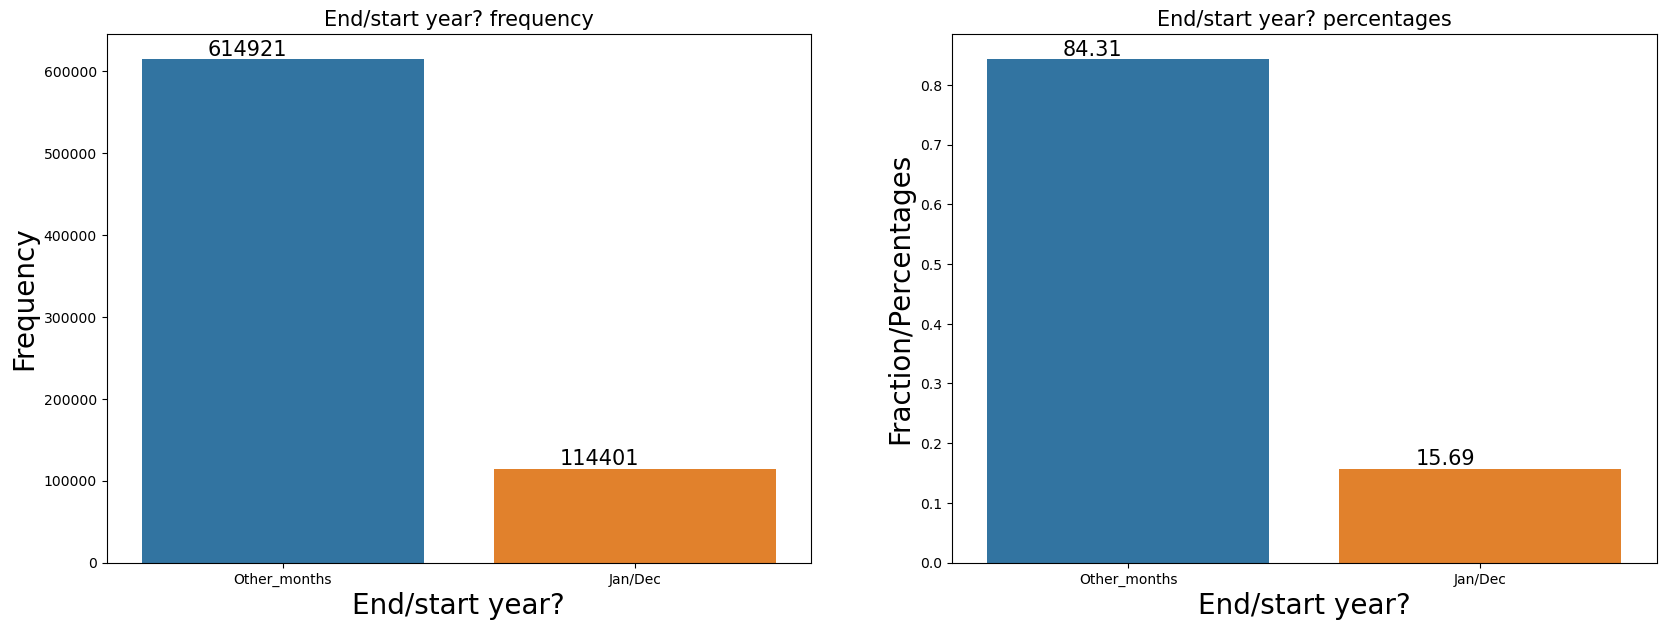

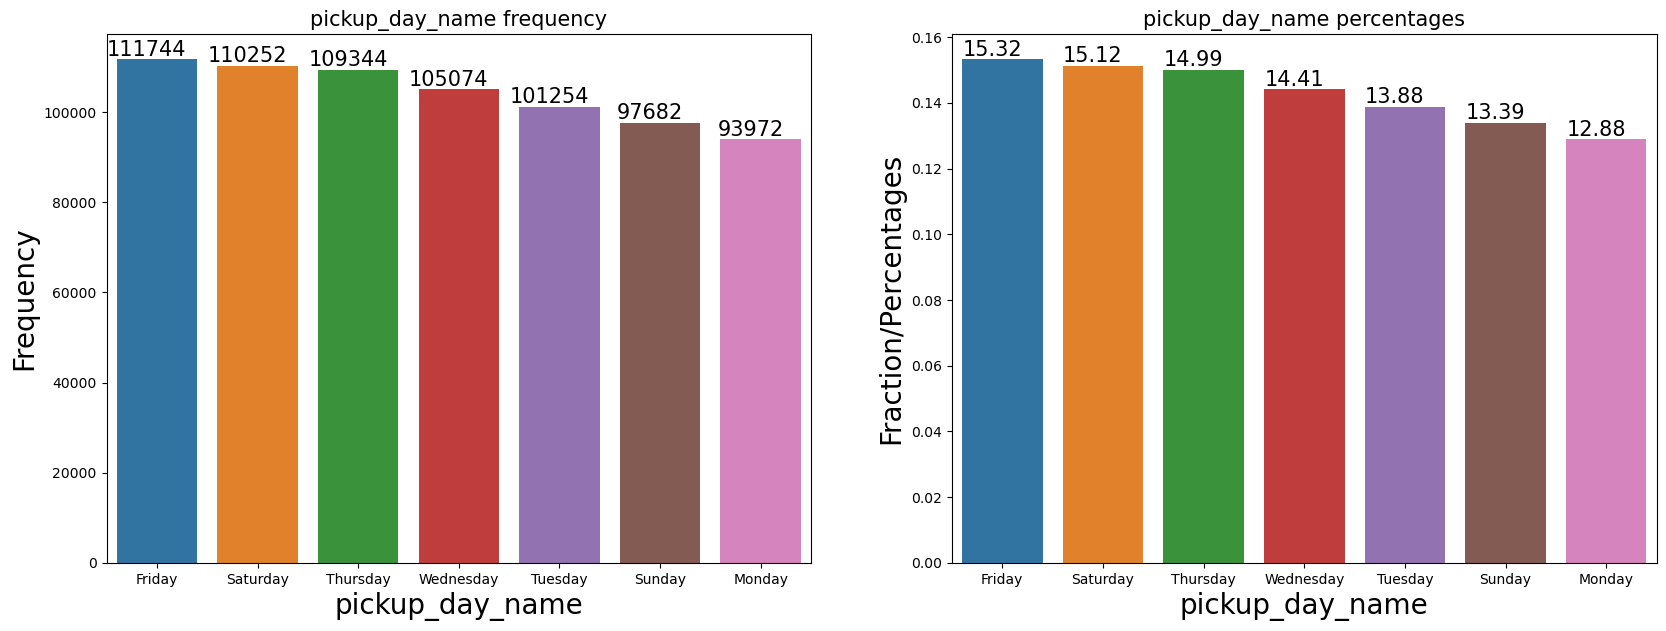

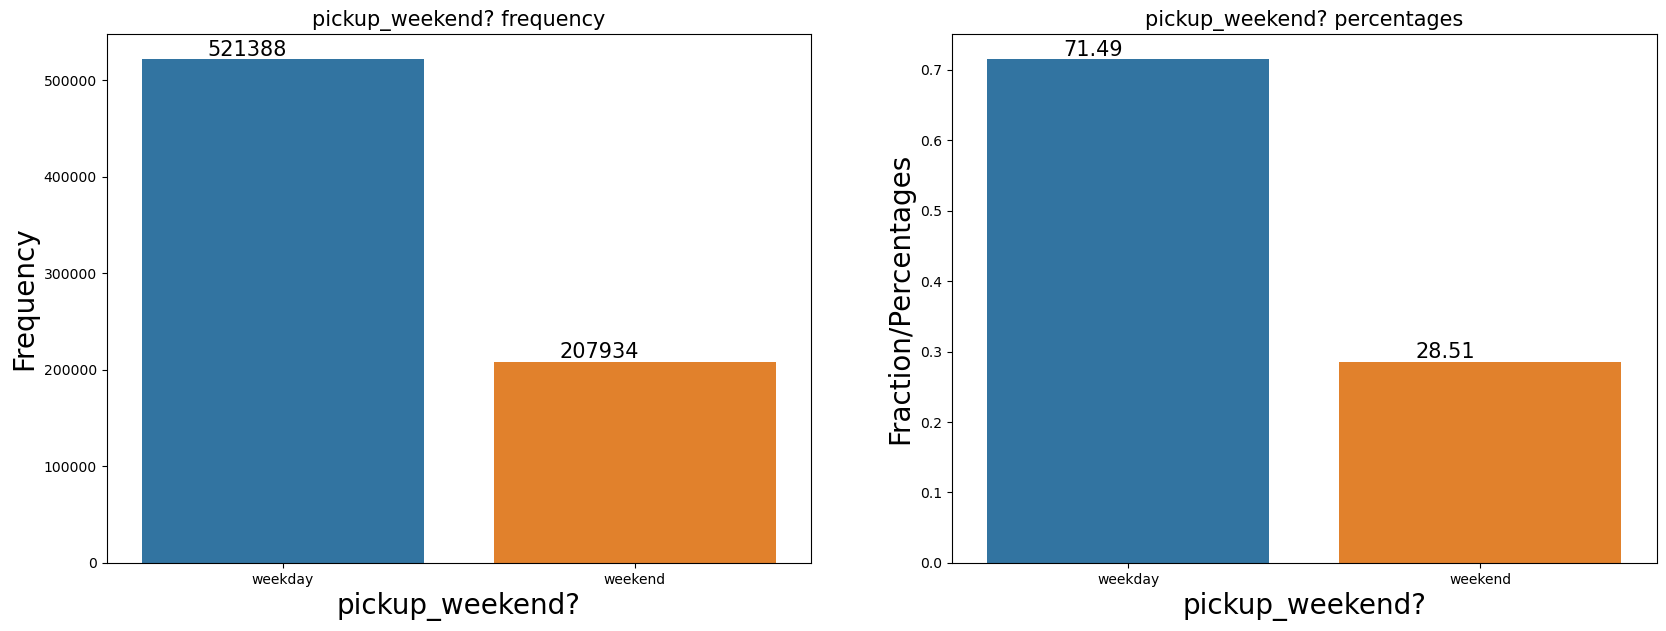

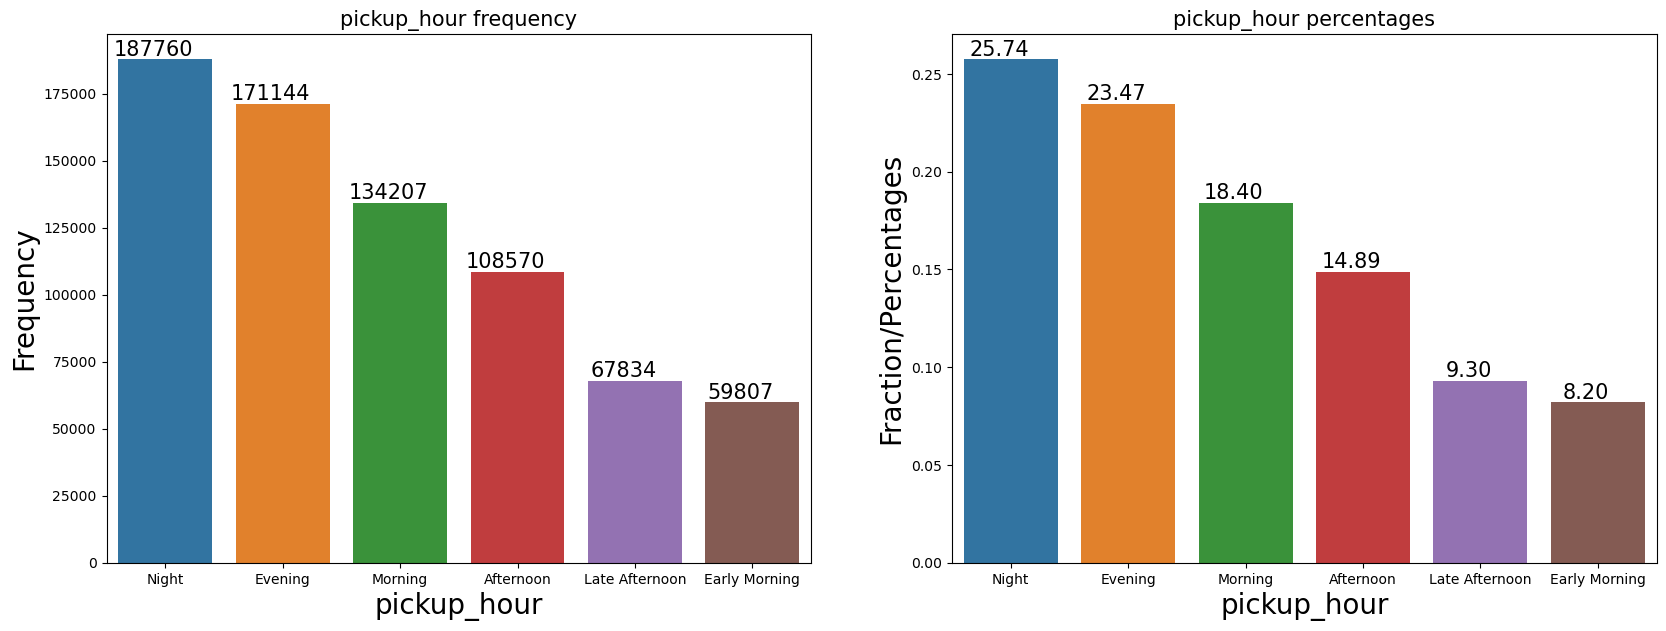

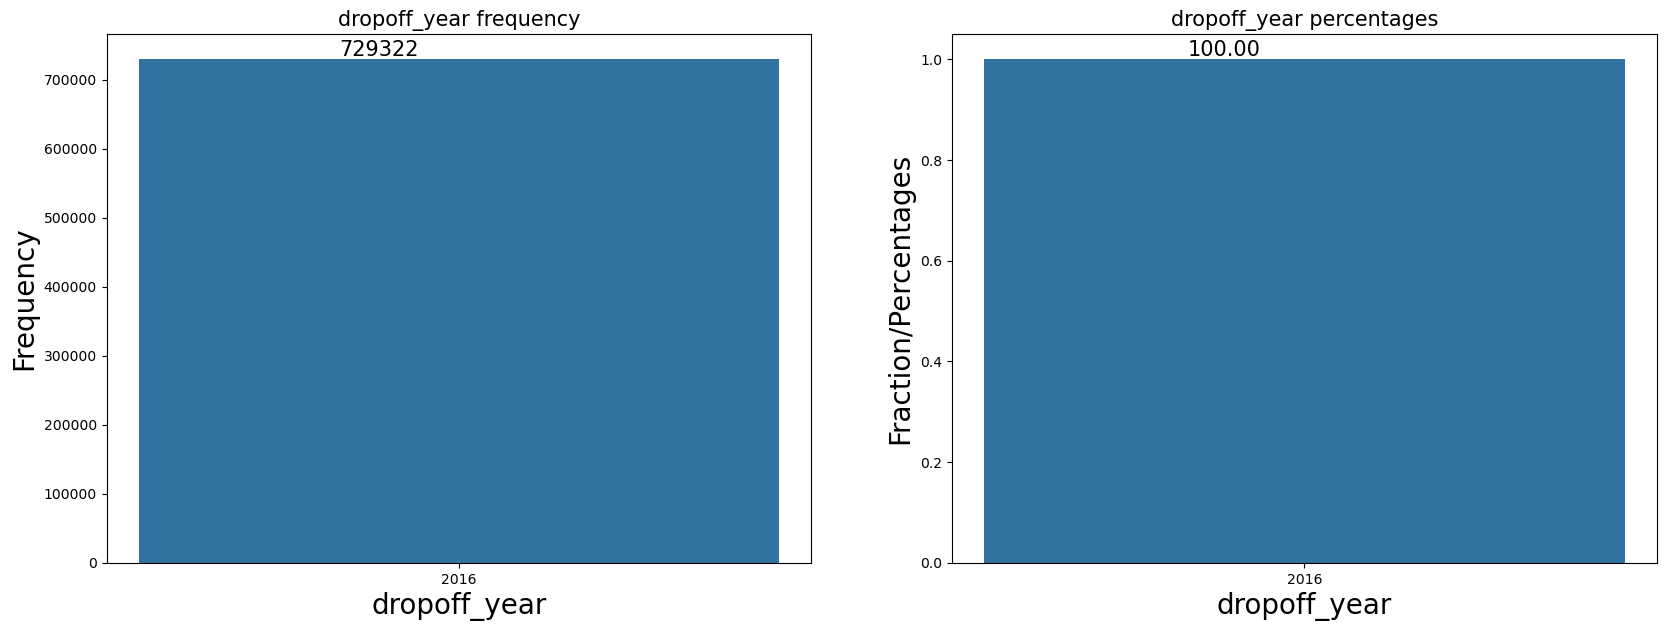

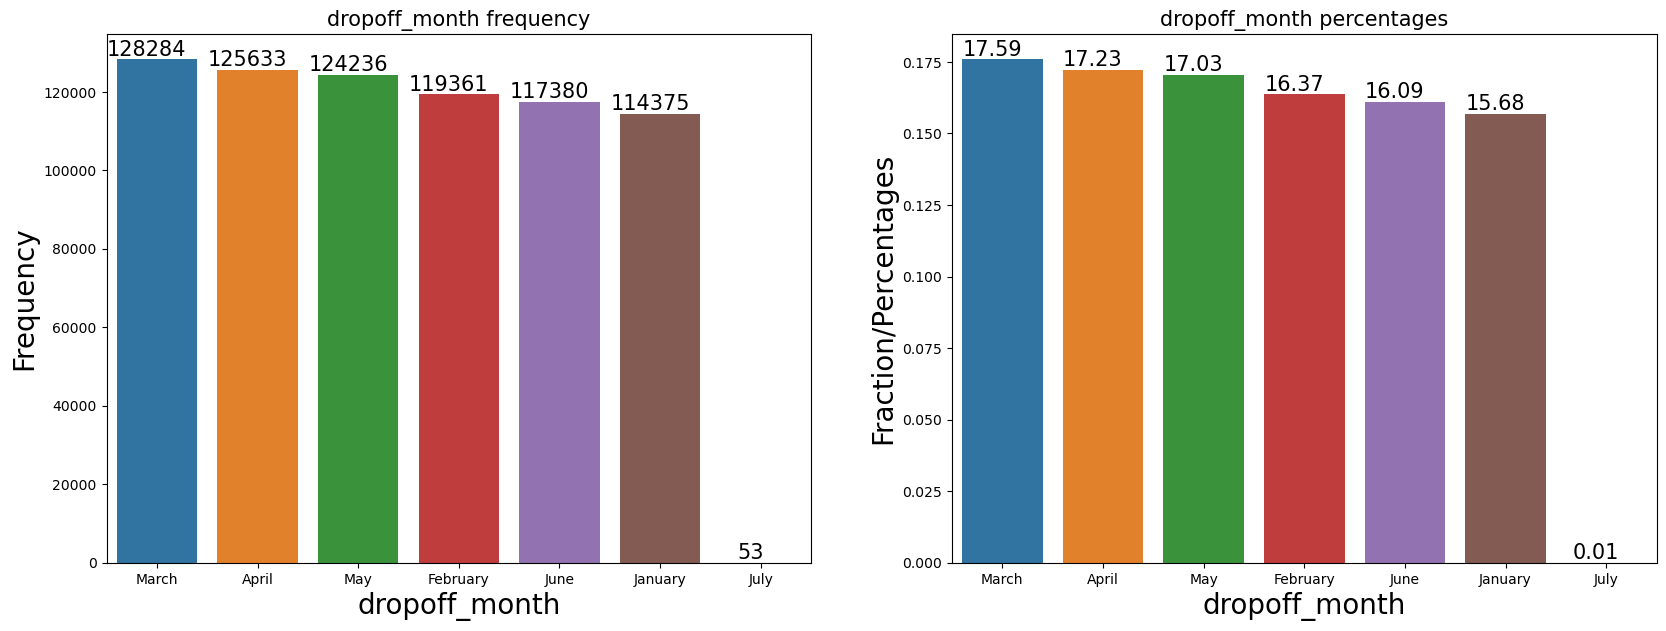

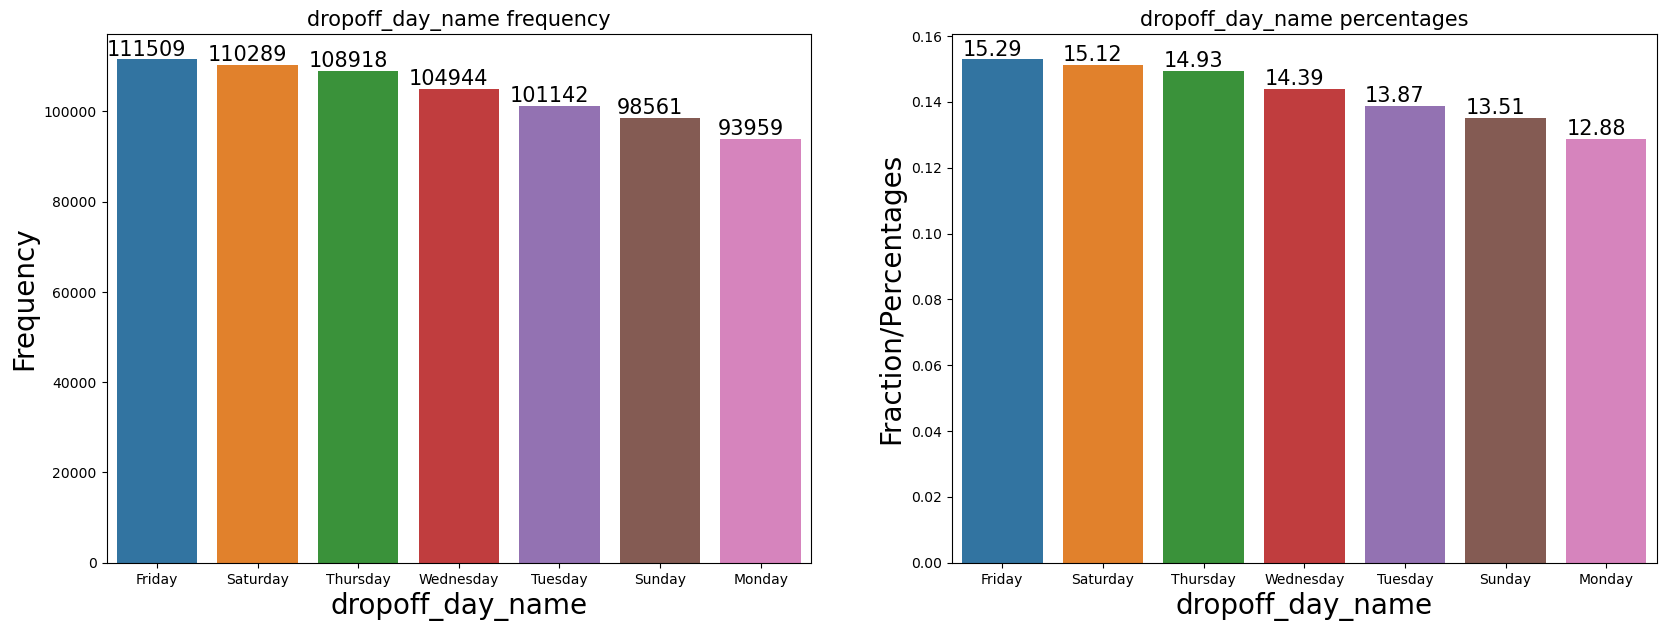

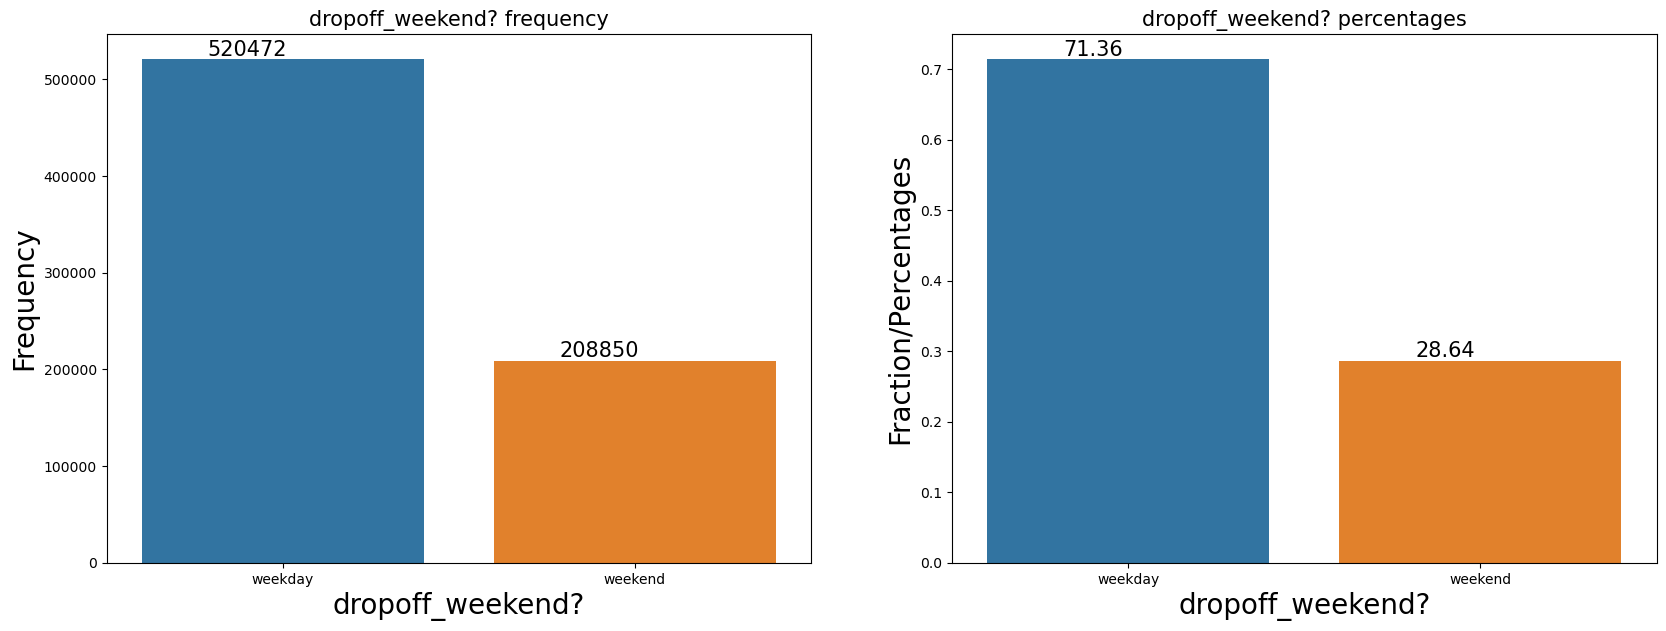

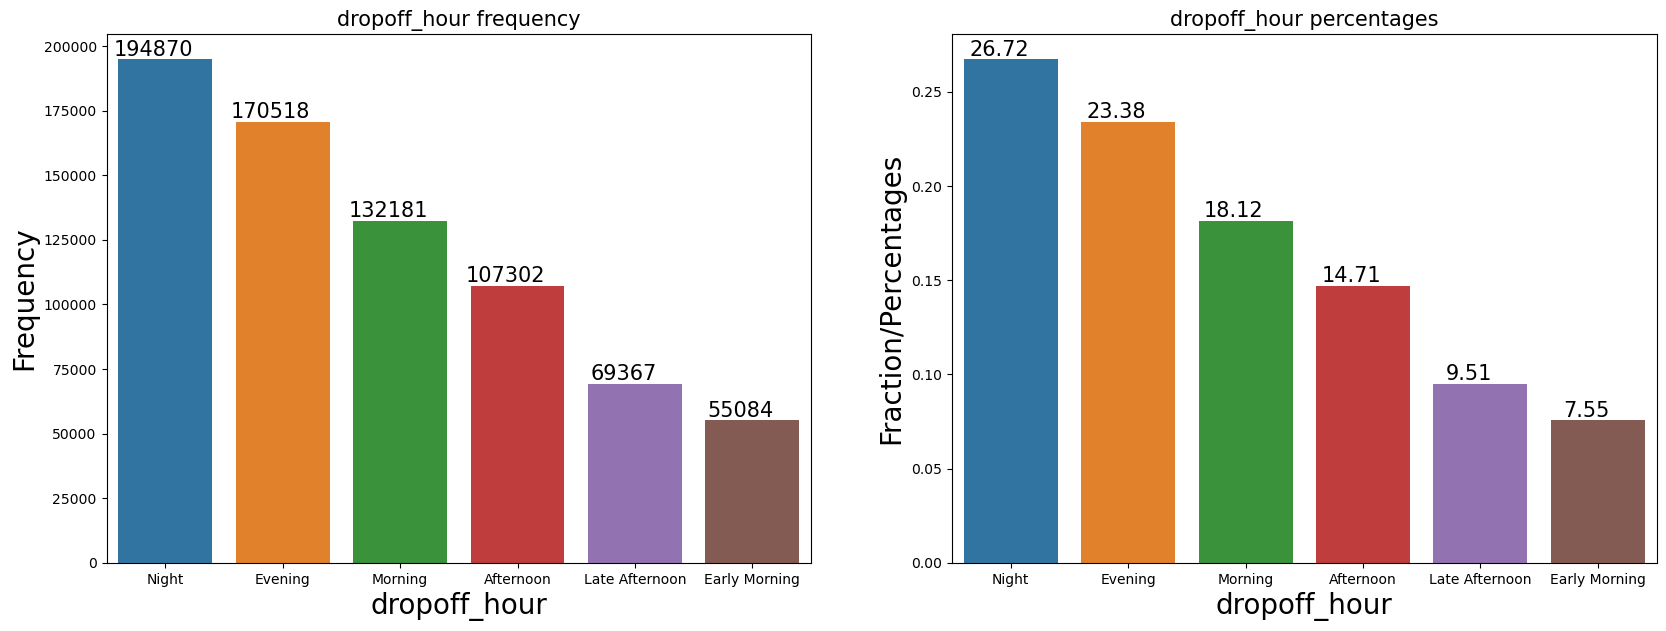

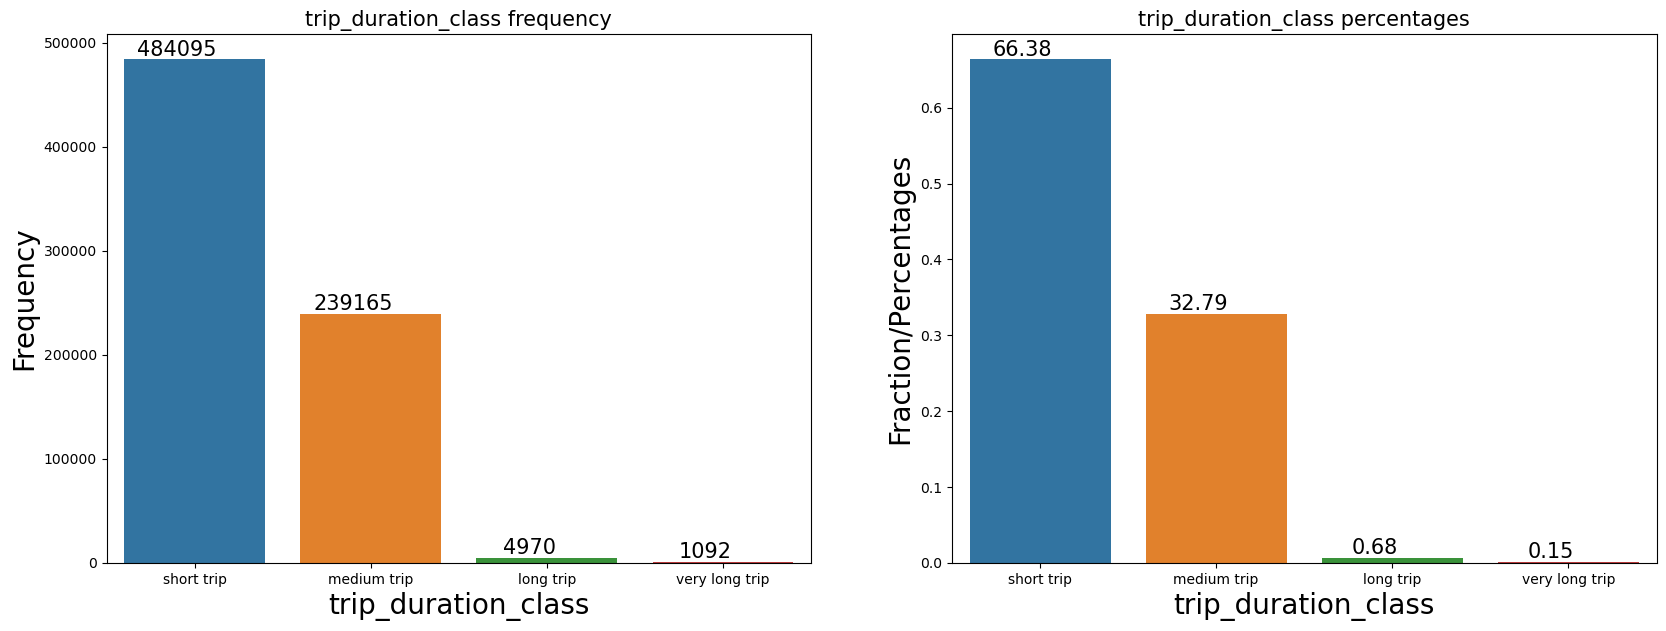

In [39]:
# List of column names which are either categorical or object datatype:
cat_cols = nyc_trip_duration.select_dtypes(include=['object','category']).columns

# Univariate analysis of categorical and object data
for col in cat_cols:
    univariate_analysis_categorical(nyc_trip_duration, col)

In [41]:
nyc_trip_duration.vendor_id[nyc_trip_duration.store_and_fwd_flag == 'Y'].value_counts()

1    4040
2       0
Name: vendor_id, dtype: int64

* Above result shows that all the offline trips were taken by the vendor_id = 1. This means that vendor_id has technical issues and vendor_id = 2 has some advance technology

**Summary:**
 * **The data provided is only for the 1st 6 months (Jan - June) of the year 2016**
 * Id column has unique values which are trip ids. So it can be dropped
 * All the data is from the year 2016 so the pickup and dropoff year columns can be dropped off from the data
 * Half of the data is vendor_id 1 and the other half is vendor_id 2
 * **99.45%** of the times the store and forward flag is **'N'** which means for almost all of the trips there is working internet connection and only 0.5% of the trips needed to store the trip data locally and upload later
 * Store and forward flag can also be dropped for the prediction modelling as it does not provide valueble signal
 * Except January all other months have similar amount of trips
 * **Friday, Saturday and Thursday** are the most **popular days** for the taxi trips
 * **Monday has the lowest amount of trips** taken compared to other days
 * Almost **50% of all the trips** happend during **Evening and Night times**
 * **66%** of trips are **short trips** which are under 15 mins

**Investigation directions fro univariate analysis:**
 * If and why January has the lowest amount of trips compared to other months?
 * Friday and Saturday are weekend days so they have lot of trips but why does Thursday have equal number of trips?
 * Is there any relation between vendor_id and the trip duration?
 * Is there any relation between time of the day and the trip duration?

In [40]:
# Dropping unnecessary columns based on the above insights:
nyc_trip_duration = nyc_trip_duration.drop(['id','pickup_year','dropoff_year','store_and_fwd_flag'], axis=1)

# Dropping Dropoff month, day_name, weekend, latitude and longitude information:
nyc_trip_duration = nyc_trip_duration.drop(['dropoff_month','dropoff_day_name','dropoff_weekend?','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1)

In [41]:
nyc_trip_duration.dtypes

vendor_id                    category
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
trip_duration                 float64
pickup_month                 category
End/start year?                object
pickup_day_name              category
pickup_weekend?              category
pickup_hour                  category
dropoff_hour                 category
trip_distance                 float64
trip_duration_class          category
dtype: object

In [42]:
nyc_trip_duration

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_duration,pickup_month,End/start year?,pickup_day_name,pickup_weekend?,pickup_hour,dropoff_hour,trip_distance,trip_duration_class
0,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,6.67,February,Other_months,Monday,weekday,Late Afternoon,Late Afternoon,1.199073,short trip
1,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,18.33,March,Other_months,Friday,weekday,Night,Night,4.129111,medium trip
2,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,27.25,February,Other_months,Sunday,weekend,Evening,Evening,7.250753,medium trip
3,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,19.02,January,Jan/Dec,Tuesday,weekday,Morning,Morning,2.361097,medium trip
4,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,14.13,February,Other_months,Wednesday,weekday,Early Morning,Early Morning,4.328534,short trip
...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,4.93,May,Other_months,Saturday,weekend,Afternoon,Afternoon,1.120223,short trip
729318,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,5.25,February,Other_months,Monday,weekday,Night,Night,0.728705,short trip
729319,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,11.22,April,Other_months,Friday,weekday,Evening,Evening,2.298776,short trip
729320,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,7.45,June,Other_months,Sunday,weekend,Morning,Morning,0.846316,short trip


### Bivariate Analysis: Numerical - Numerical variables:

In [43]:
nyc_trip_duration.dtypes

vendor_id                    category
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
trip_duration                 float64
pickup_month                 category
End/start year?                object
pickup_day_name              category
pickup_weekend?              category
pickup_hour                  category
dropoff_hour                 category
trip_distance                 float64
trip_duration_class          category
dtype: object

In [44]:
# Considering only the numerical data (ignoring Latitude and Longitude information):
numerical_data = nyc_trip_duration[['passenger_count','trip_duration','trip_distance']]
display(numerical_data)
print(numerical_data.dtypes)

,passenger_count,trip_duration,trip_distance
0,1,6.67,1.199073
1,2,18.33,4.129111
2,2,27.25,7.250753
3,6,19.02,2.361097
4,1,14.13,4.328534
...,...,...,...
729317,2,4.93,1.120223
729318,1,5.25,0.728705
729319,1,11.22,2.298776
729320,1,7.45,0.846316


passenger_count      int64
trip_duration      float64
trip_distance      float64
dtype: object


* Passenger count, trip_distance and trip duration are the only 3 variables which are of the type integer/float

In [45]:
# Correlation matrix:
corr_matrix = numerical_data.dropna().corr()
corr_matrix

,passenger_count,trip_duration,trip_distance
passenger_count,1.000000,0.013022,0.009175
trip_duration,0.013022,1.000000,0.125772
trip_distance,0.009175,0.125772,1.000000


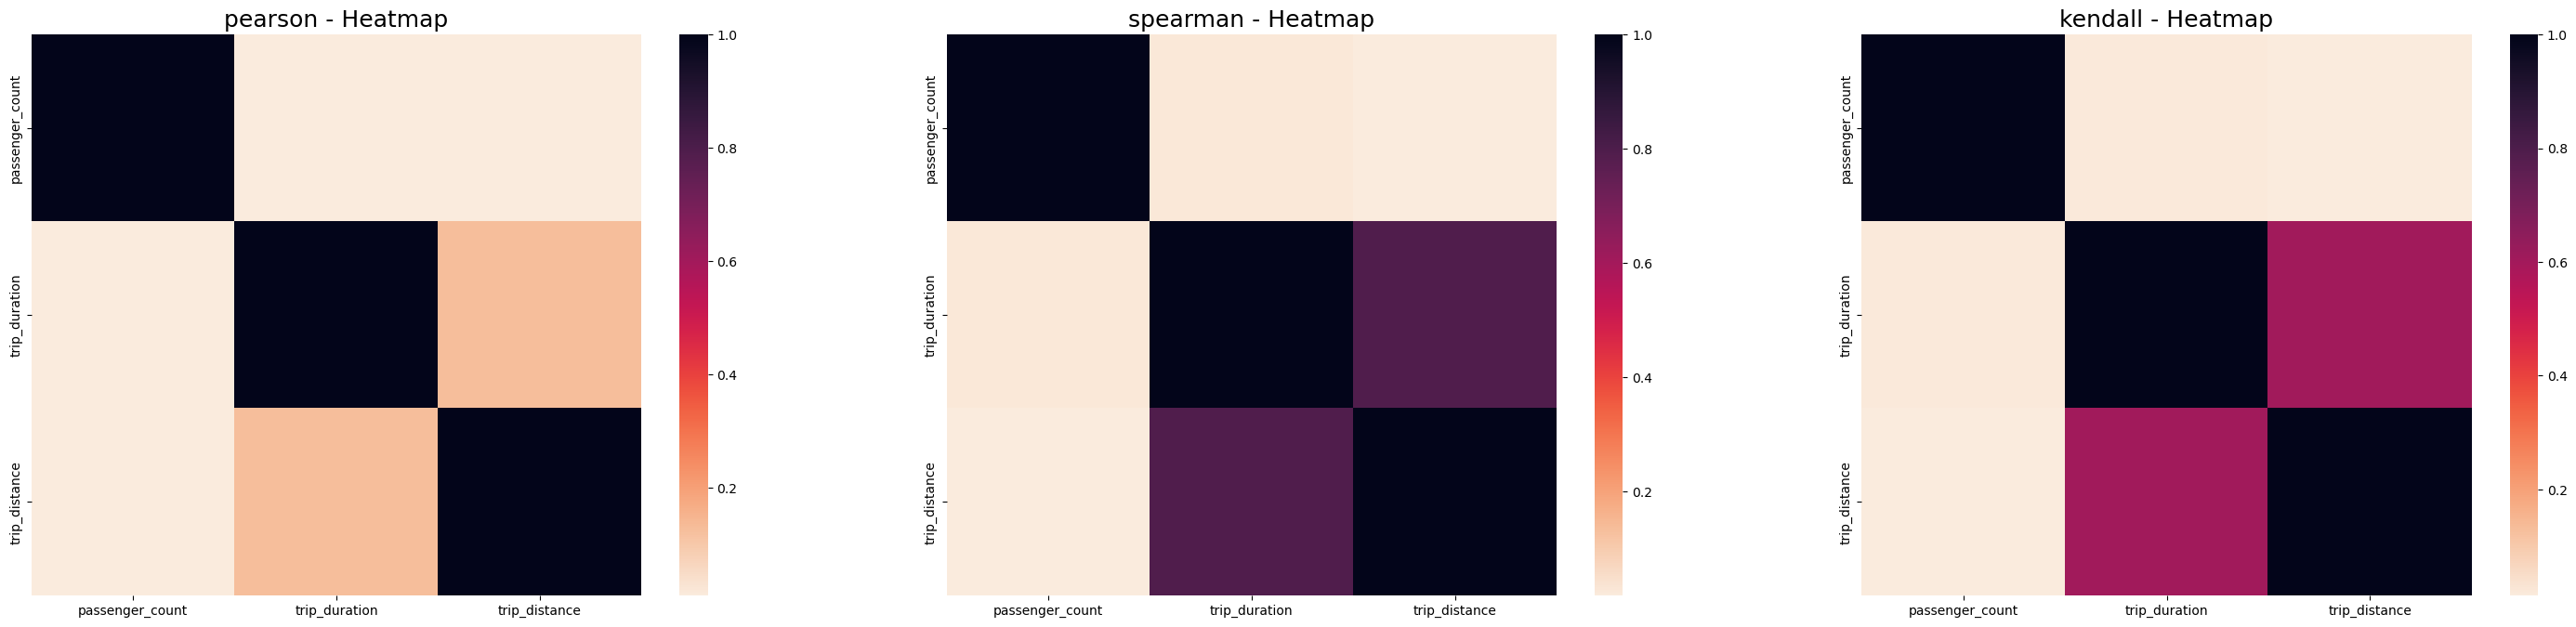

In [46]:
# Creating a list of all the 3 correlation matrix:
correlation_methods = ['pearson','spearman','kendall']

plt.figure(figsize=(36,8), dpi=100)

for j,i in enumerate(correlation_methods):    
    plt.subplot(1, len(correlation_methods), j+1)
    
    # Correlation matrix using all 3 correlation methods:
    corr_matrix_all = numerical_data.dropna().corr(method=i)
    sns.heatmap(corr_matrix_all, cmap=sns.cm.rocket_r)
    
    plt.title(f'{i} - Heatmap', fontsize=18)

* There are only 3 numeric variables and they don't have any strong correlation among them

#### Scatterplot:

In [47]:
# Removing outliers before plotting a pairplot:
numerical_data_pair_plot_df = numerical_data.copy()

for col in list(numerical_data.columns):
    numerical_data_pair_plot_df[col] = np.log(numerical_data[col] + 6000)

<Figure size 2000x1000 with 0 Axes>

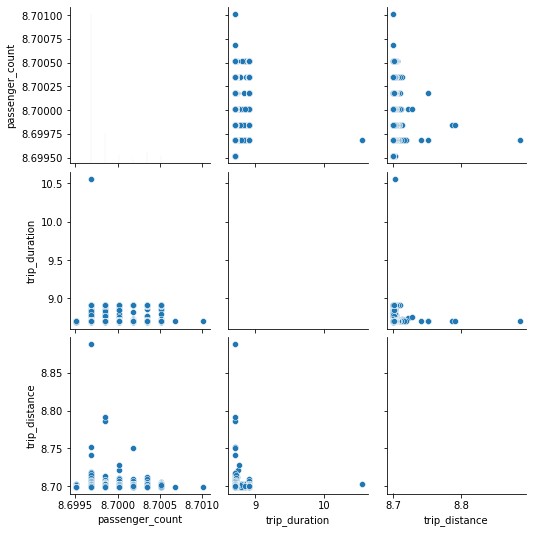

In [48]:
plt.figure(figsize=(20,10),dpi=100)
sns.pairplot(numerical_data_pair_plot_df)

* It is clear that the passenger count does not influence the trip duration
* This information can be used during the feature engineering step of model building

#Note: We can see that the trips with highest duration have the lowest distance. This needs to be investigated

In [49]:
nyc_trip_duration.loc[nyc_trip_duration['trip_distance'] == 0]

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_duration,pickup_month,End/start year?,pickup_day_name,pickup_weekend?,pickup_hour,dropoff_hour,trip_distance,trip_duration_class
263,2,2016-06-28 11:21:00,2016-06-28 11:25:00,2,4.00,June,Other_months,Tuesday,weekday,Morning,Morning,0.0,short trip
327,2,2016-03-26 13:34:38,2016-03-26 13:37:17,1,2.65,March,Other_months,Saturday,weekend,Afternoon,Afternoon,0.0,short trip
795,2,2016-06-13 16:49:52,2016-06-13 17:04:49,5,14.95,June,Other_months,Monday,weekday,Late Afternoon,Evening,0.0,short trip
1176,1,2016-02-29 21:39:52,2016-02-29 21:44:08,1,4.27,February,Other_months,Monday,weekday,Night,Night,0.0,short trip
1257,2,2016-03-13 11:38:36,2016-03-13 12:00:46,2,22.17,March,Other_months,Sunday,weekend,Morning,Afternoon,0.0,medium trip
...,...,...,...,...,...,...,...,...,...,...,...,...,...
728720,2,2016-05-05 21:32:43,2016-05-05 21:32:57,2,0.23,May,Other_months,Thursday,weekday,Night,Night,0.0,short trip
728775,2,2016-03-13 20:06:40,2016-03-13 20:14:24,1,7.73,March,Other_months,Sunday,weekend,Evening,Evening,0.0,short trip
728838,2,2016-05-29 04:04:32,2016-05-29 04:11:33,2,7.02,May,Other_months,Sunday,weekend,Early Morning,Early Morning,0.0,short trip
729025,2,2016-04-06 18:03:34,2016-04-06 18:26:23,1,22.82,April,Other_months,Wednesday,weekday,Evening,Evening,0.0,medium trip


* Here we can see that the distance travelled is Zero but other variables like trip duration and passenger count say otherwise
* One reason might be due to incorrect data capturing
* Another reason might be a technical glitch
* This incorrect data needs to be handled before proceeding to modelling phase

### Bivariate Analysis: Numerical - Categorical variables:

List of Hypothesis and investigation to perform under this combination:
 * Weekends have less trip duration due to less traffic congestion on the roads
 * Do people travel farther on weekends?

In [50]:
# Function to perform Bivariate analysis for numerical-categorical data:
def Bivariate_analysis_num_cat(data, num, cat, target_class):
    # Creating columns of data filtered by the category:
    num_cat1 = data.loc[data[cat] == target_class ][num]
    num_cat2 = data.loc[~(data[cat] == target_class)][num]
    
    # Calculating Means of both the independent variables:
    m1, m2 = num_cat1.mean(), num_cat2.mean()
    
    # Calculating P-values of 2-Sampled Z-Test and 2-Sampled T-test:
    _, z_p_value = ztest(num_cat1, num_cat2)
    _,t_p_value = ttest_ind(a=num_cat1, b=num_cat2, equal_var=True)
    
    table = pd.pivot_table(data=data, values=num, columns=cat, aggfunc='mean')
    
    # Printing P-values of both 2-sampled Z-Tests and T-Tests:
    print('P-value of 2-sampled Z-Test: ',round(z_p_value, 2))
    if z_p_value > 0.05:
        print('we fail to reject the Null hypothesis')
    else:
        print('We can safely reject the Null hypothesis')
    
    print('\nP-value of 2-sampled T-Test: ',round(t_p_value,2))
    if t_p_value > 0.05:
        print('We fail to reject the Null hypothesis')
    else:
        print('We can safely reject the Null hypothesis')
    
    # Printing category wise means of the numerical variables:
    print('\n')
    print(table)
    
    # Bar plot of num-cat variables:
    plt.figure(figsize=(15,6), dpi=140)
    
    plt.subplot(1,2,1)
    axy = sns.barplot(x=list(data[cat].unique()), y=[m2,m1])
    for p in axy.patches:
        axy.annotate('{:1.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=15)
    plt.xlabel('{} - category'.format(cat))
    plt.ylabel('{} - numerical'.format(num))
    plt.title('Bar plot - Num-Cat')
    
    # Box plot of num-cat variables:
    plt.subplot(1,2,2)
    sns.boxplot(x=cat, y=num, data=data)
    plt.xlabel('{} - category'.format(cat))
    plt.ylabel('{} - numerical'.format(num))
    plt.title('Box plot - Num-Cat')
    
    plt.show()

Q1. Do Weekends have less trip duration due to less traffic congestion on the roads?
  * H0: The trip duration is same on both weekdays and weekends
  * H1: The trip duration during weekends is less

P-value of 2-sampled Z-Test:  0.0
We can safely reject the Null hypothesis

P-value of 2-sampled T-Test:  0.0
We can safely reject the Null hypothesis


pickup_weekend?    weekday    weekend
trip_duration    16.185305  15.081101


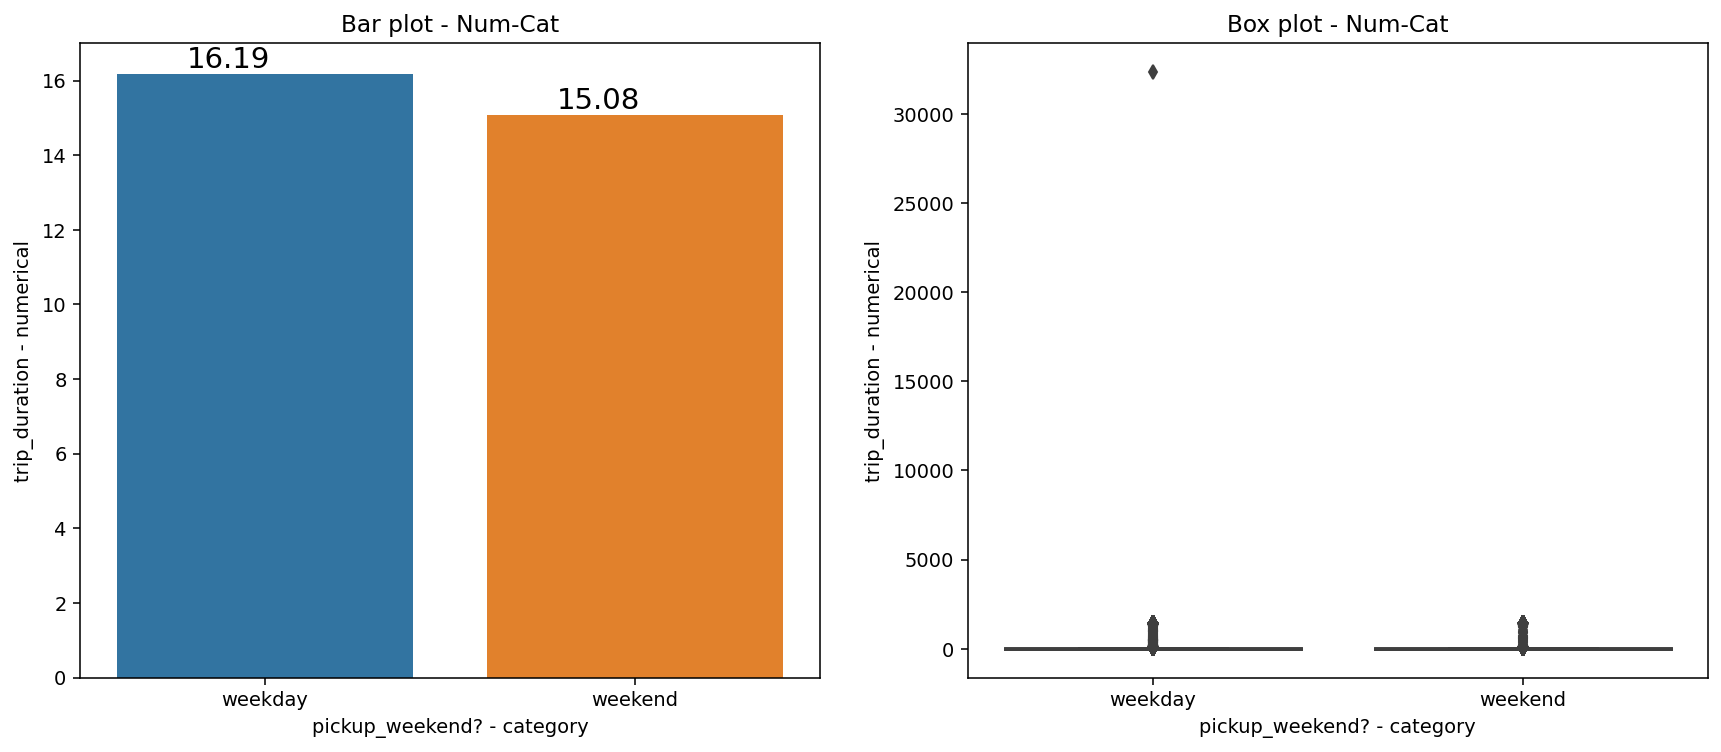

In [51]:
Bivariate_analysis_num_cat(nyc_trip_duration, 'trip_duration', 'pickup_weekend?', 'weekend')

**Inference:**
 * From the above graph we can observe that the average trip duration is less on weekends compared to the weekedays
 * The difference observed is statistically significant as the P-values of Z and T tests (0,0) < 0.05
 * **We can safely reject the Null hypothesis (H0)** and accept the Alternate hypothesis (H1)

Q2. Do people travel longer distances during weekends?
 * H0: People travel the same distance on both weekdays and weekends
 * H1: People travel longer distances on weekends

P-value of 2-sampled Z-Test:  0.0
We can safely reject the Null hypothesis

P-value of 2-sampled T-Test:  0.0
We can safely reject the Null hypothesis


pickup_weekend?   weekday   weekend
trip_distance    3.412503  3.512942


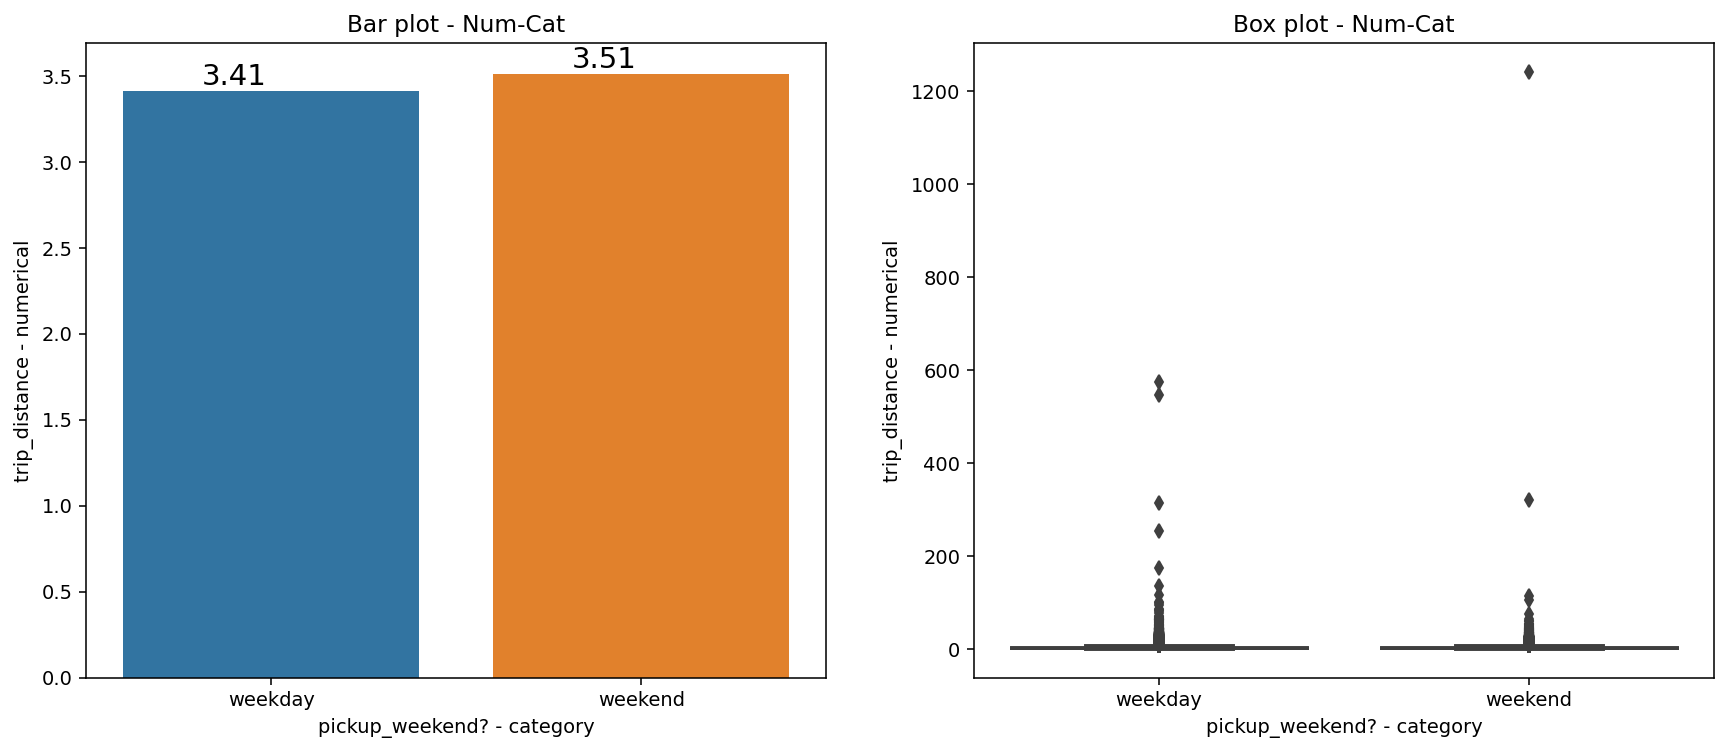

In [52]:
Bivariate_analysis_num_cat(nyc_trip_duration, 'trip_distance', 'pickup_weekend?', 'weekend')

* People travel longer distances during the weekends as observed from the above graph
* This result is statistically significant as observed from the P-values from Z and T tests (0,0) which are less than 0.05
* We can safely reject the Null hypohtesis (H0) and accept the Alternate hypothesis (H1)

Q3. Do people travel longer distances in the months of January and December?
 * H0: People travel the same distance in all the months
 * H1: People travel different distances in January and December

P-value of 2-sampled Z-Test:  0.0
We can safely reject the Null hypothesis

P-value of 2-sampled T-Test:  0.0
We can safely reject the Null hypothesis


End/start year?  Jan/Dec  Other_months
trip_distance    3.37489      3.453464


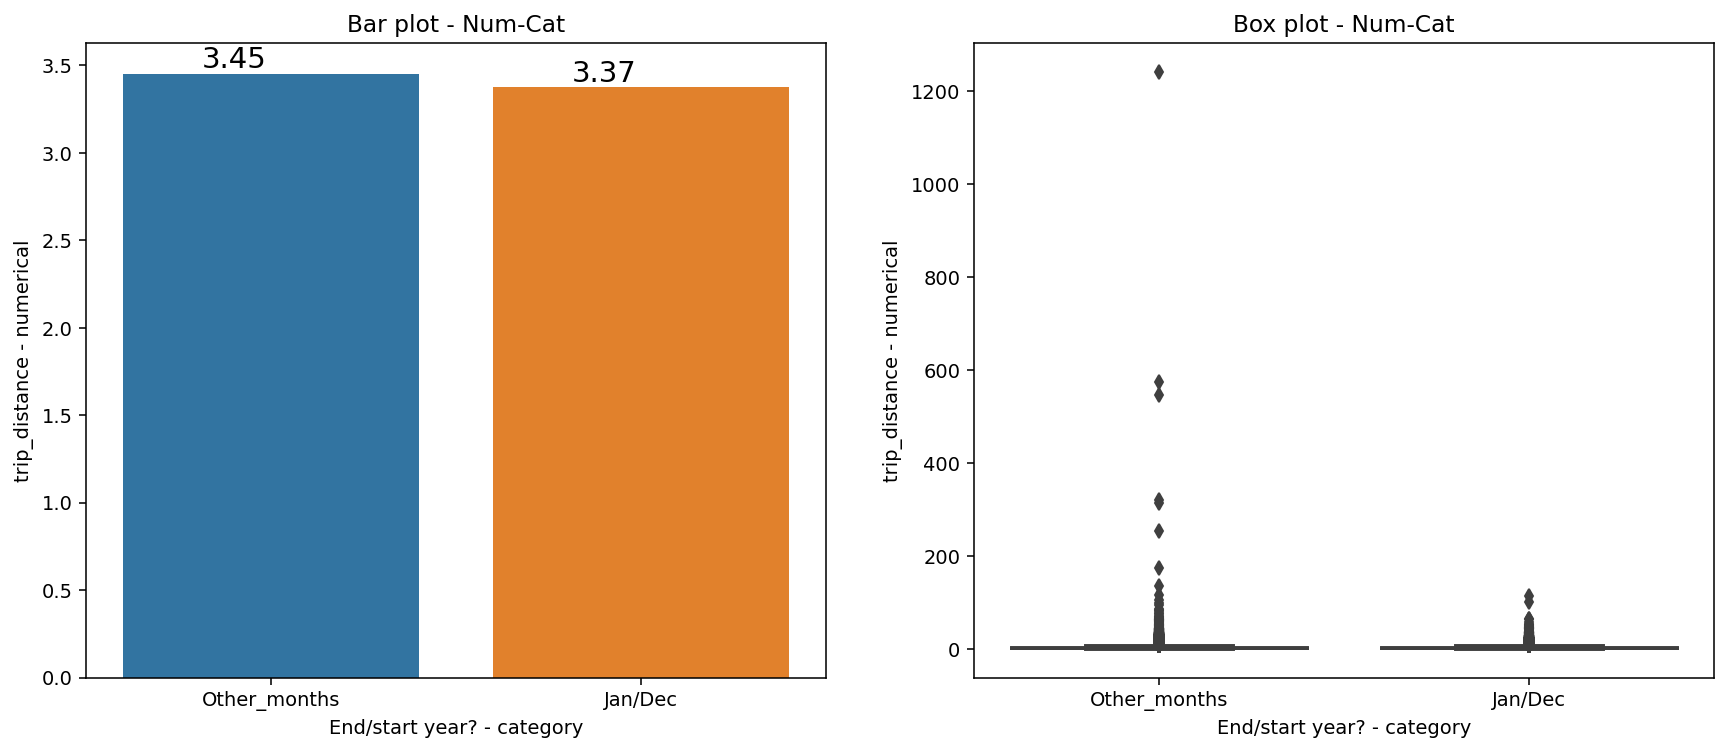

In [53]:
Bivariate_analysis_num_cat(nyc_trip_duration, 'trip_distance', 'End/start year?', 'Jan/Dec')

* People travel less distance during the months of January and December compared to other months
* P-values of both Z and T tests are < 0.05 so the difference is statistically significant. Hence, we can safely reject the Null hypothesis (H0) and accept the Alternate hypothesis (H1)

Q4. Does Vendor_id = 2 take longer trips?
 * H0: Both the vendors take trips of similar duration
 * H1: Both vendors take trips of varying duration

P-value of 2-sampled Z-Test:  0.0
We can safely reject the Null hypothesis

P-value of 2-sampled T-Test:  0.0
We can safely reject the Null hypothesis


vendor_id              1          2
trip_duration  13.951604  17.535608


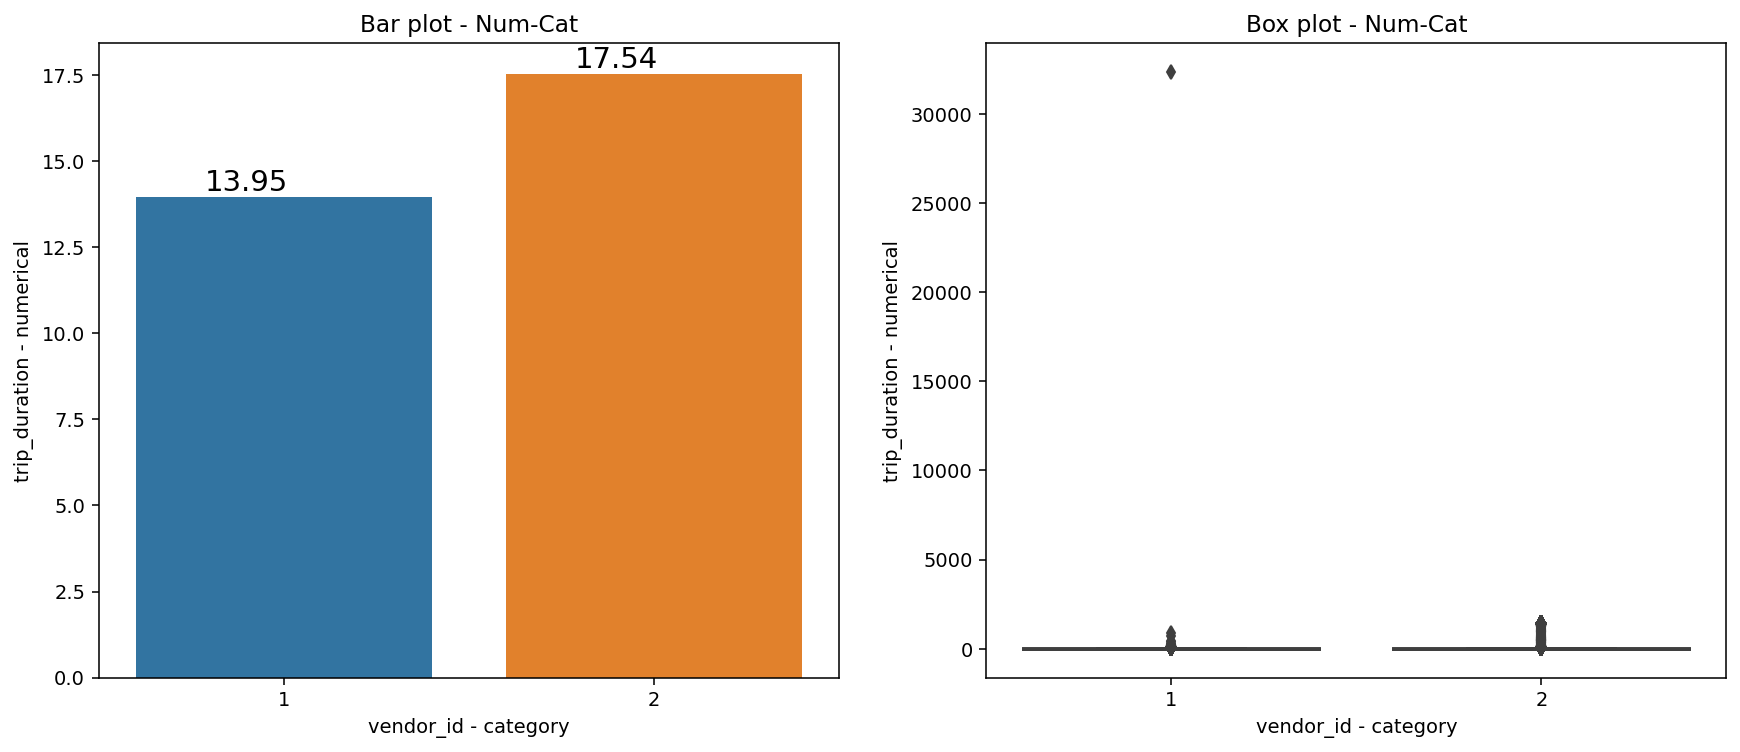

In [54]:
Bivariate_analysis_num_cat(nyc_trip_duration, 'trip_duration', 'vendor_id', 1)

* From the above graph it is understood that the vendor_id = 2 takes longer trips 
* The difference is statistically significant based on the P-value (0.0) < 0.05. Hence, we can safely reject the Null hypothesis (H0) and accept the Alternate hypothesis (H1)

Q5. Does Vendor_id = 2 take farther trips?
 * H0: Both the vendors take trips of similar distance
 * H1: Both vendors take trips of varying distance

P-value of 2-sampled Z-Test:  0.0
We can safely reject the Null hypothesis

P-value of 2-sampled T-Test:  0.0
We can safely reject the Null hypothesis


vendor_id             1         2
trip_distance  3.410717  3.467537


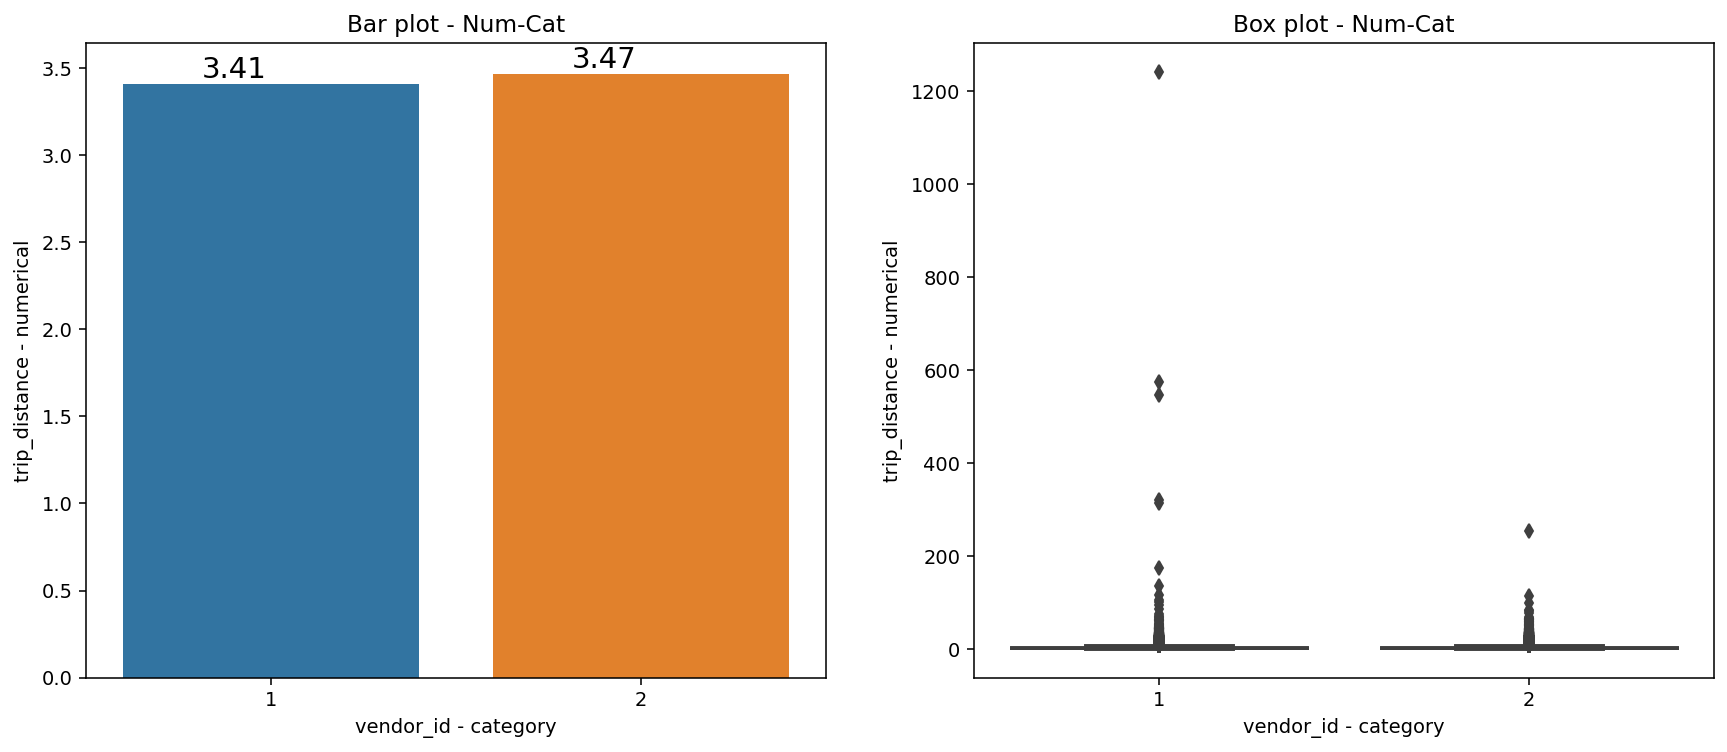

In [55]:
Bivariate_analysis_num_cat(nyc_trip_duration, 'trip_distance', 'vendor_id', 1)

* The distribution of both the vendor_ids is similar

Q6. Are the trips longer at some parts of the day?

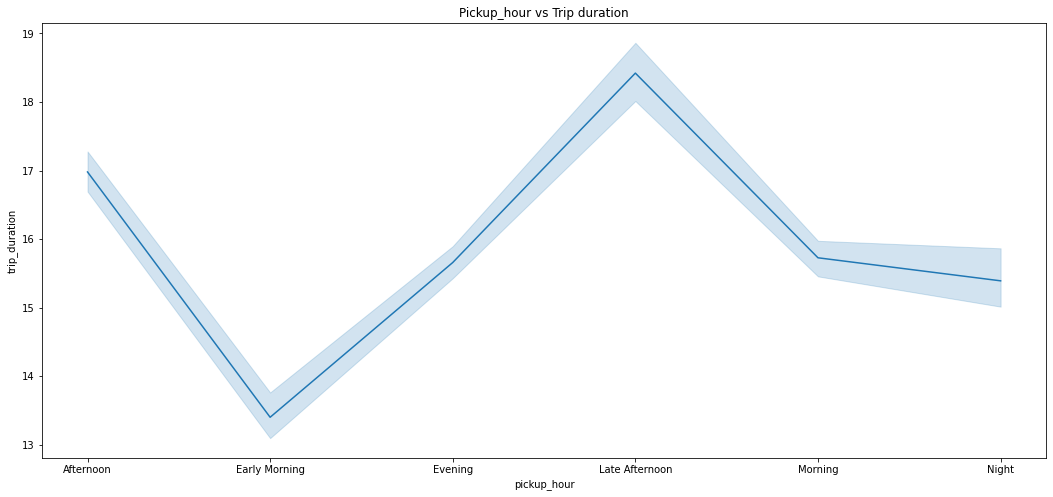

In [56]:
plt.figure(figsize=(18,8))
sns.lineplot(x='pickup_hour',y='trip_duration', data=nyc_trip_duration)
plt.title('Pickup_hour vs Trip duration')
plt.show()

* From the above graph we can clearly see that trip durations are high during the Late Afternoon (3PM - 5PM)

Q7. Are the trips longer at different days of the week?

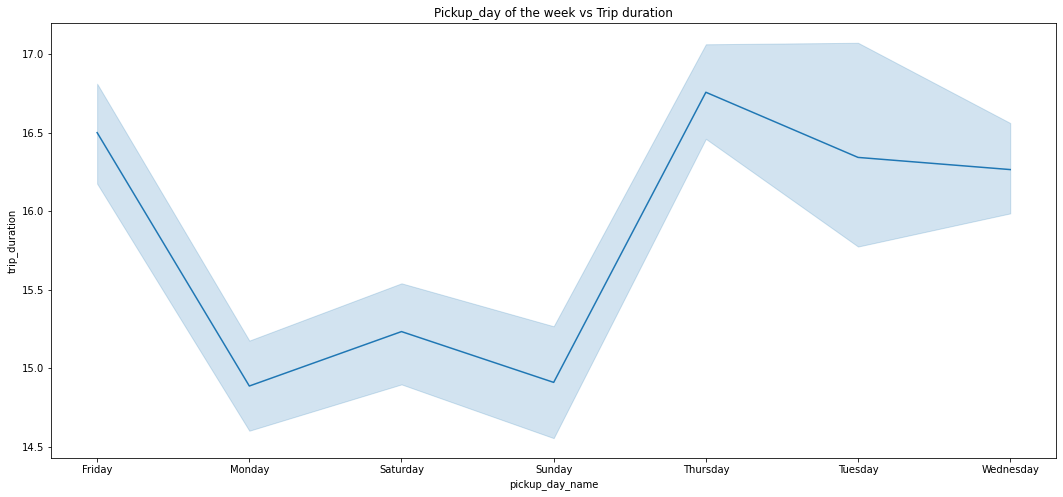

In [57]:
plt.figure(figsize=(18,8))
sns.lineplot(x='pickup_day_name',y='trip_duration', data=nyc_trip_duration)
plt.title('Pickup_day of the week vs Trip duration')
plt.show()

* From the above graph we can see that trip durations are longer Tuesday through Friday. This maybe due to the high traffic during these days of the week

Q8. Are the trips longer at different months of the year?

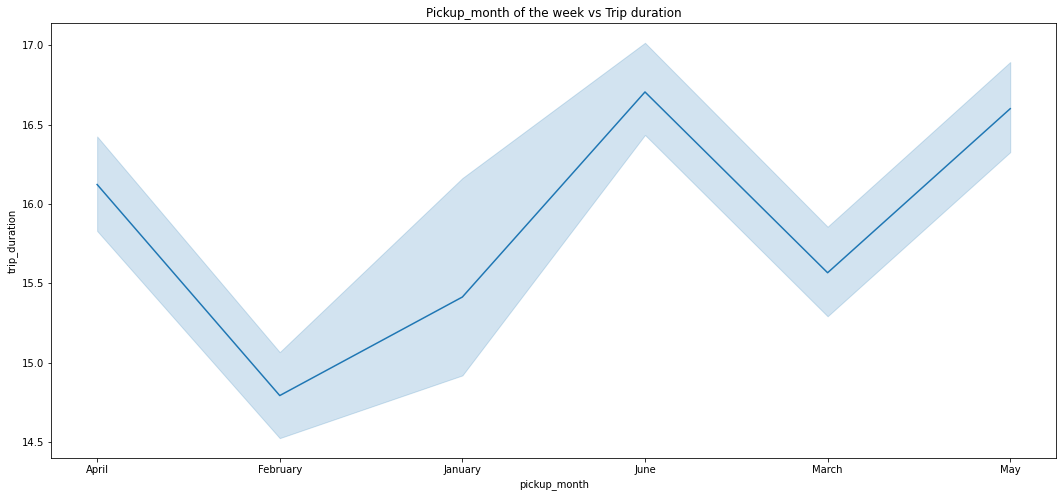

In [58]:
plt.figure(figsize=(18,8))
sns.lineplot(x='pickup_month',y='trip_duration', data=nyc_trip_duration)
plt.title('Pickup_month of the week vs Trip duration')
plt.show()

* From the above graph we can see that June month has the highest trip durations compared to other months

### Bivariate Analysis: Categorical - Categorical variables:

##### List of Hypotheses to check under this cat-cat bivariate analysis
1. Does trip duration depend on the time of the day taxi was taken?
2. Is the trip duration going to be less on the weekends?
3. Does trip duration depend on the month it was taken?
4. Does trip duration depend on the vendor_id?

In [59]:
# Function to perform Bivariate analysis of categorical - categorical variables:
def Bivariate_analysis_cat_cat(df, cat, target):
    
    # Taking copy of the data with required categorical and target variables:
    df1 = df[[cat,target]]
    
    # Creating the cross tab table:
    cross_tab_table = pd.crosstab(df1[cat], df1[target])
    
    # Performing chi-squared hypothesis test:
    chi, p_val, dof, excepted = chi2_contingency(cross_tab_table)
    
    # Checking the significance based on the p-value:
    if p_val < 0.05:
        significance = True
    else:
        significance = False
    
    # Plotting the countplot and displaying the P-value and if the difference is significant or not based on the P-value:
    plt.figure(figsize=(10,6))
    sns.countplot(df1, x=cat, hue=target)
    plt.title('P-value: {}\n Difference significant? = {}\n'.format(round(p_val,8), significance))
    
    # Calculating the percentages cross tab table:
    cross_tab_percentages_table = pd.crosstab(df1[cat], df1[target], normalize='index')
    
    # Plotting the percentage stacked barplot:
    plt.figure(figsize=(10,6), dpi=100)
    cross_tab_percentages_table.plot(kind='bar', stacked=True, title=str(cross_tab_percentages_table), figsize=(10,6))

Q1. Does trip duration depend on the time of the day taxi was taken?

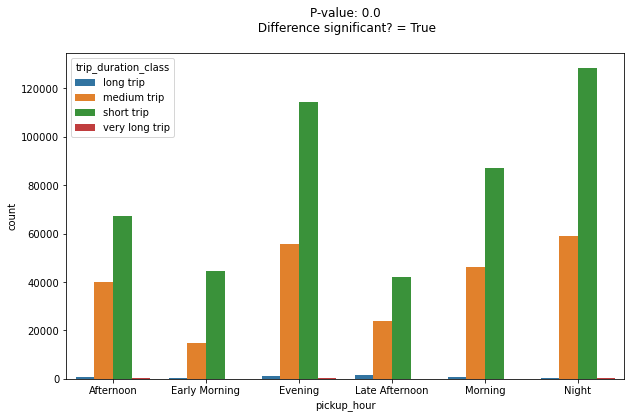

<Figure size 1000x600 with 0 Axes>

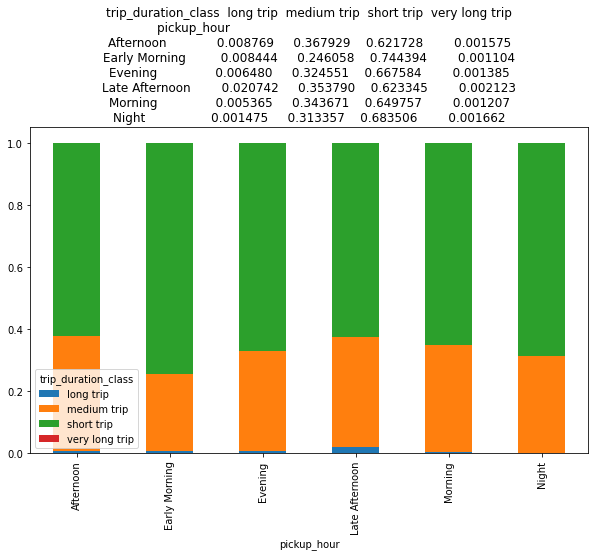

In [60]:
# Dataframe containing only pickup_hour and trip_duration_class categories for bivariate categorical - categorical analysis:
nyc_pickup_hour_df_cat_cat = nyc_trip_duration[['pickup_hour','trip_duration_class']]

# Function call to perform bivariate analysis on 2 categorical variables:
Bivariate_analysis_cat_cat(nyc_pickup_hour_df_cat_cat, 'pickup_hour', 'trip_duration_class')

* From the above graph we can see that the trip durations are short for lot of trips during early morning and night time. This can be understood as the traffic during those times is usually minimal
* The difference is significant as the P-value (0.0) < 0.05

Q2. Is the trip duration going to be less on the weekends?

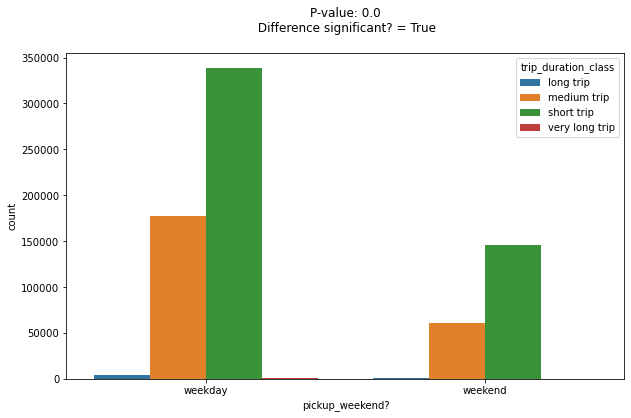

<Figure size 1000x600 with 0 Axes>

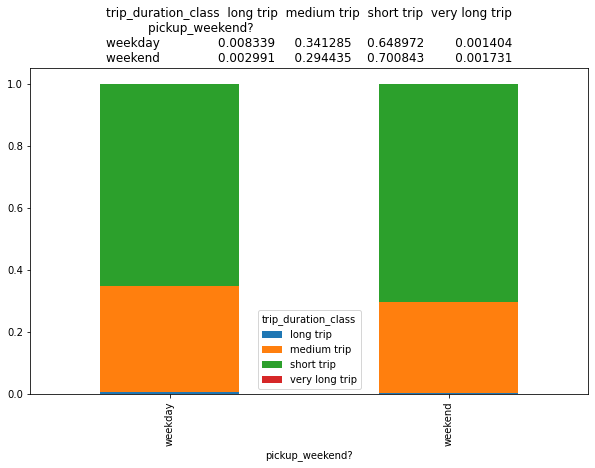

In [61]:
# Dataframe containing only pickup_weekend? and trip_duration_class categories for bivariate categorical - categorical analysis:
nyc_weekends_df_cat_cat = nyc_trip_duration[['pickup_weekend?','trip_duration_class']]

# Function call to perform bivariate analysis on 2 categorical variables:
Bivariate_analysis_cat_cat(nyc_weekends_df_cat_cat, 'pickup_weekend?', 'trip_duration_class')

* Weekend trips are shorter compared to weekday trips as the traffic is usually less on the weekends
* This difference is significant as indicated by the P-value (0.0) < 0.05. Hence, we can reject the Null hypothesis (H0) and accept the Alternate hypothesis (H1)

Q3. Does trip duration depend on the month it was taken?

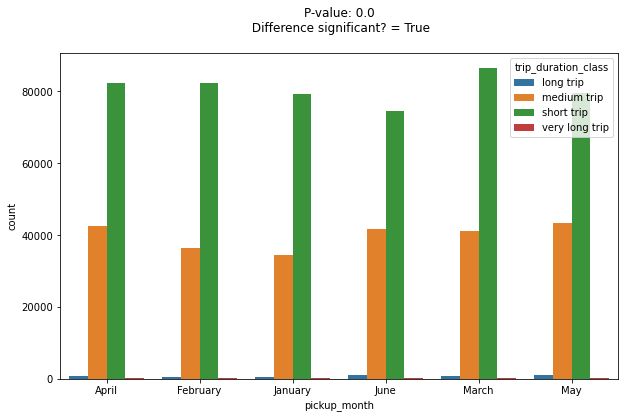

<Figure size 1000x600 with 0 Axes>

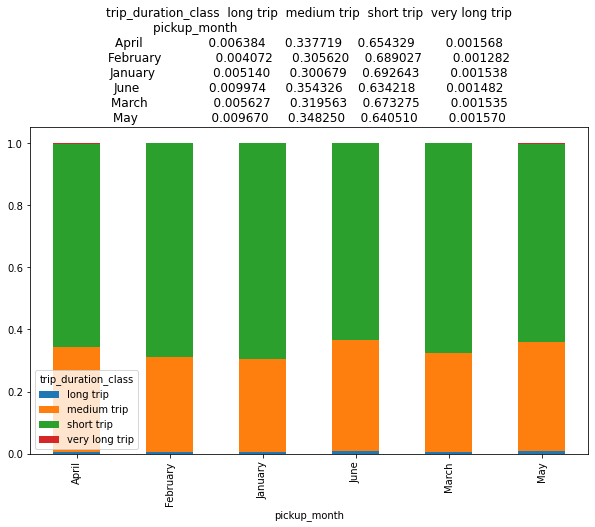

In [62]:
# Dataframe containing only pickup_month and trip_duration_class categories for bivariate categorical - categorical analysis:
nyc_pickup_month_df_cat_cat = nyc_trip_duration[['pickup_month','trip_duration_class']]

# Function call to perform bivariate analysis on 2 categorical variables:
Bivariate_analysis_cat_cat(nyc_pickup_month_df_cat_cat, 'pickup_month', 'trip_duration_class')

* There more longer trips in the month of June compared to other months. This is statistically significant as the P-value (0.0) < 0.05

Q4. Does trip duration depend on the vendor_id?

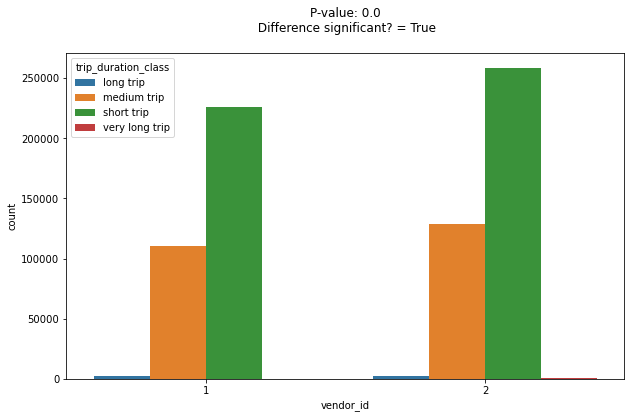

<Figure size 1000x600 with 0 Axes>

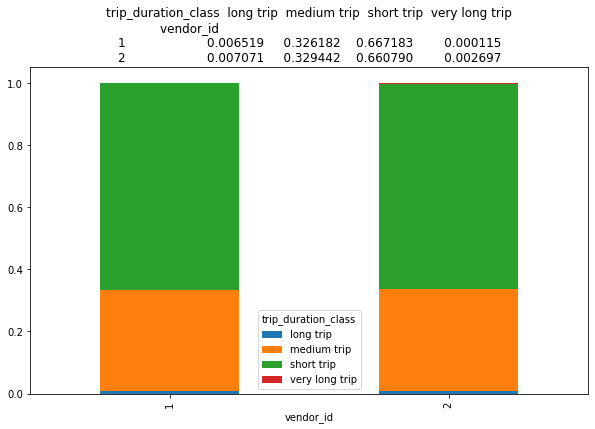

In [63]:
# Dataframe containing only vendor_id and trip_duration_class categories for bivariate categorical - categorical analysis:
nyc_vendor_id_df_cat_cat = nyc_trip_duration[['vendor_id','trip_duration_class']]

# Function call to perform bivariate analysis on 2 categorical variables:
Bivariate_analysis_cat_cat(nyc_vendor_id_df_cat_cat, 'vendor_id', 'trip_duration_class')

* Vendor_id = 2 has more number of long and very long trips and this is statistically significant based on the P-value (0.0) < 0.05